# Plot specific genes expression across groups

**Author: Caroline Larkin**

**Research Group: Gottschalk Lab, Department of Immunology, University of Pittsburgh**

Notebook based on [link](https://liana-py.readthedocs.io/en/latest/notebooks/targeted.html)

In [1]:
import numpy as np
import pandas as pd
import anndata as ad 
import scanpy as sc
from thefuzz import fuzz
from thefuzz import process

import celltypist
from celltypist import models

import liana as li

import matplotlib.pyplot as plt
import seaborn as sns 

sample_ids = ["SA149P", "SA154", "SA220", "SA222", "SA227", "SA159", "SA168", "SA225"]
sample_labels = ["UPA", "UPA", "Naive", "Resistant", "Resistant", "Remission", "Remission", "Remission"] 

sample_ids = sample_ids[2:]
sample_labels = sample_labels[2:] 
print(sample_ids)

data_dir = "../Data/EMATB8322/"

# Download base models from celltypist
models.download_models()

/ihome/rgottschalk/cil8/envs/rnaseq/lib/python3.13/site-packages/celltypist/classifier.py:11: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  from scanpy import __version__ as scv
📂 Storing models in /ihome/rgottschalk/cil8/.celltypist/data/models
⏩ Skipping [1/60]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/60]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/60]: Adult_COVID19_PBMC.pkl (file exists)
⏩ Skipping [4/60]: Adult_CynomolgusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [5/60]: Adult_Human_MTG.pkl (file exists)
⏩ Skipping [6/60]: Adult_Human_PancreaticIslet.pkl (file exists)
⏩ Skipping [7/60]: Adult_Human_PrefrontalCortex.pkl (file exists)
⏩ Skipping [8/60]: Adult_Human_Skin.pkl (file exists)
⏩ Skipping [9/60]: Adult_Human_Vascular.pkl (file exists)
⏩ Skipping [10/60]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [11/60]: Adult_Mouse_OlfactoryBulb.pkl (file exists)
⏩ Skipping [12/60]: Adult_Pig_Hippocampus.pkl (file exi

['SA220', 'SA222', 'SA227', 'SA159', 'SA168', 'SA225']


## 1. Load data

In [2]:
# Load celltypist immune model
model = models.Model.load(model = "Immune_All_High.pkl")

In [3]:
ads = []
for id, label in zip(sample_ids, sample_labels):
    cur_ad = sc.read_mtx(filename=f"{data_dir}{id}/processed_counts.mtx").transpose()
    gene_names = pd.read_csv(f"{data_dir}{id}/processed_gene_names.csv", header=None)
    cur_ad.var_names = gene_names.values.flatten()
    print()#print(gene_names.values.flatten())
    barcodes = pd.read_csv(f"{data_dir}{id}/processed_metadata.csv", usecols=["barcode"])
    cur_ad.obs_names = barcodes.values.flatten()
    cur_ad.obs_names_make_unique()
    cur_ad.obs["Group"] = [label]* len(barcodes)
    cur_ad.obs["Sample"] = [id] * len(barcodes)
    display(cur_ad)

    # create a temporary copy of adata to preprocess
    temp = cur_ad.copy()
    # Normalizing to median total counts
    sc.pp.normalize_total(temp, target_sum=10000)
    # Logarithmize the data
    sc.pp.log1p(temp)

    predictions = celltypist.annotate(temp, model=model)
    new_ad = predictions.to_adata();
    cur_ad.obs["cell_type"] = new_ad.obs["predicted_labels"]
    cell_counts = cur_ad.obs["cell_type"].value_counts()
    # removing cell types with low counts
    print(cell_counts)
    keep_cell_types = cell_counts[cell_counts.values > 10]
    #print(keep_cell_types.index.values)
    cur_ad = cur_ad[cur_ad.obs["cell_type"].isin(keep_cell_types.index.values)]
    #adata = adata[adata.obs[condition_key]=='Resistant'].copy()
    sc.pp.normalize_total(cur_ad)
    sc.pp.log1p(cur_ad)
    display(cur_ad)
    
    ads.append(cur_ad); 
    del temp
    del new_ad

    sc.pp.neighbors(cur_ad, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(cur_ad)
    sc.tl.paga(cur_ad)
    sc.pl.paga(cur_ad, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(cur_ad, init_pos='paga')
    print("\n\n\n")

AnnData object with n_obs × n_vars = 1832 × 16171
    obs: 'Group', 'Sample'

🔬 Input data has 1832 cells and 16171 genes
🔗 Matching reference genes in the model
🧬 4688 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


cell_type
Fibroblasts                   683
Endothelial cells             560
Macrophages                   450
T cells                        52
DC                             34
Epithelial cells               19
ILC                            12
B cells                        12
Monocytes                       7
Double-positive thymocytes      1
Myelocytes                      1
Plasma cells                    1
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 1822 × 16171
    obs: 'Group', 'Sample', 'cell_type'
    uns: 'log1p'

/ihome/rgottschalk/cil8/envs/rnaseq/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
... storing 'Group' as categorical
... storing 'Sample' as categorical


AnnData object with n_obs × n_vars = 5189 × 17673
    obs: 'Group', 'Sample'

🔬 Input data has 5189 cells and 17673 genes
🔗 Matching reference genes in the model
🧬 5000 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


cell_type
Fibroblasts                   2816
Macrophages                   1025
Endothelial cells              534
T cells                        360
DC                             162
Plasma cells                   103
B cells                         58
Monocytes                       55
ILC                             48
pDC                             12
Epithelial cells                 6
Cycling cells                    3
Mast cells                       3
Double-positive thymocytes       2
Mono-mac                         1
Myelocytes                       1
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 5173 × 17673
    obs: 'Group', 'Sample', 'cell_type'
    uns: 'log1p'

... storing 'Group' as categorical
... storing 'Sample' as categorical


AnnData object with n_obs × n_vars = 4774 × 16896
    obs: 'Group', 'Sample'

🔬 Input data has 4774 cells and 16896 genes
🔗 Matching reference genes in the model
🧬 4930 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


cell_type
Fibroblasts                   1615
Endothelial cells             1198
Macrophages                    939
T cells                        311
Plasma cells                   177
DC                             152
B cells                        134
Monocytes                       95
ILC                             77
Epithelial cells                47
pDC                             12
Double-positive thymocytes       6
Mono-mac                         4
Myelocytes                       2
B-cell lineage                   1
Cycling cells                    1
ETP                              1
DC precursor                     1
Double-negative thymocytes       1
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 4757 × 16896
    obs: 'Group', 'Sample', 'cell_type'
    uns: 'log1p'

... storing 'Group' as categorical
... storing 'Sample' as categorical


AnnData object with n_obs × n_vars = 3206 × 16155
    obs: 'Group', 'Sample'

🔬 Input data has 3206 cells and 16155 genes
🔗 Matching reference genes in the model
🧬 4850 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


cell_type
Endothelial cells             1033
Fibroblasts                    809
T cells                        627
B cells                        176
Macrophages                    161
Monocytes                      152
ILC                            114
DC                              64
Plasma cells                    44
Epithelial cells                15
pDC                              5
Double-positive thymocytes       4
DC precursor                     1
B-cell lineage                   1
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 3195 × 16155
    obs: 'Group', 'Sample', 'cell_type'
    uns: 'log1p'

... storing 'Group' as categorical
... storing 'Sample' as categorical


AnnData object with n_obs × n_vars = 5058 × 17498
    obs: 'Group', 'Sample'

🔬 Input data has 5058 cells and 17498 genes
🔗 Matching reference genes in the model
🧬 5011 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


cell_type
Macrophages          1957
Fibroblasts          1201
T cells               608
Endothelial cells     444
DC                    402
Monocytes             172
Mast cells            121
B cells                56
ILC                    51
Plasma cells           30
pDC                     9
Mono-mac                4
Cycling cells           2
Epithelial cells        1
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 5042 × 17498
    obs: 'Group', 'Sample', 'cell_type'
    uns: 'log1p'

... storing 'Group' as categorical
... storing 'Sample' as categorical


AnnData object with n_obs × n_vars = 1783 × 13829
    obs: 'Group', 'Sample'

🔬 Input data has 1783 cells and 13829 genes
🔗 Matching reference genes in the model
🧬 4345 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


cell_type
Fibroblasts                   807
T cells                       256
Macrophages                   185
Endothelial cells             153
ILC                           128
B cells                        77
Epithelial cells               50
Plasma cells                   35
Monocytes                      31
DC                             30
Double-positive thymocytes     13
Mast cells                      5
B-cell lineage                  3
DC precursor                    3
Cycling cells                   2
Mono-mac                        2
Megakaryocytes/platelets        1
Myelocytes                      1
pDC                             1
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 1765 × 13829
    obs: 'Group', 'Sample', 'cell_type'
    uns: 'log1p'

... storing 'Group' as categorical
... storing 'Sample' as categorical


... storing 'Mac Subtype' as categorical


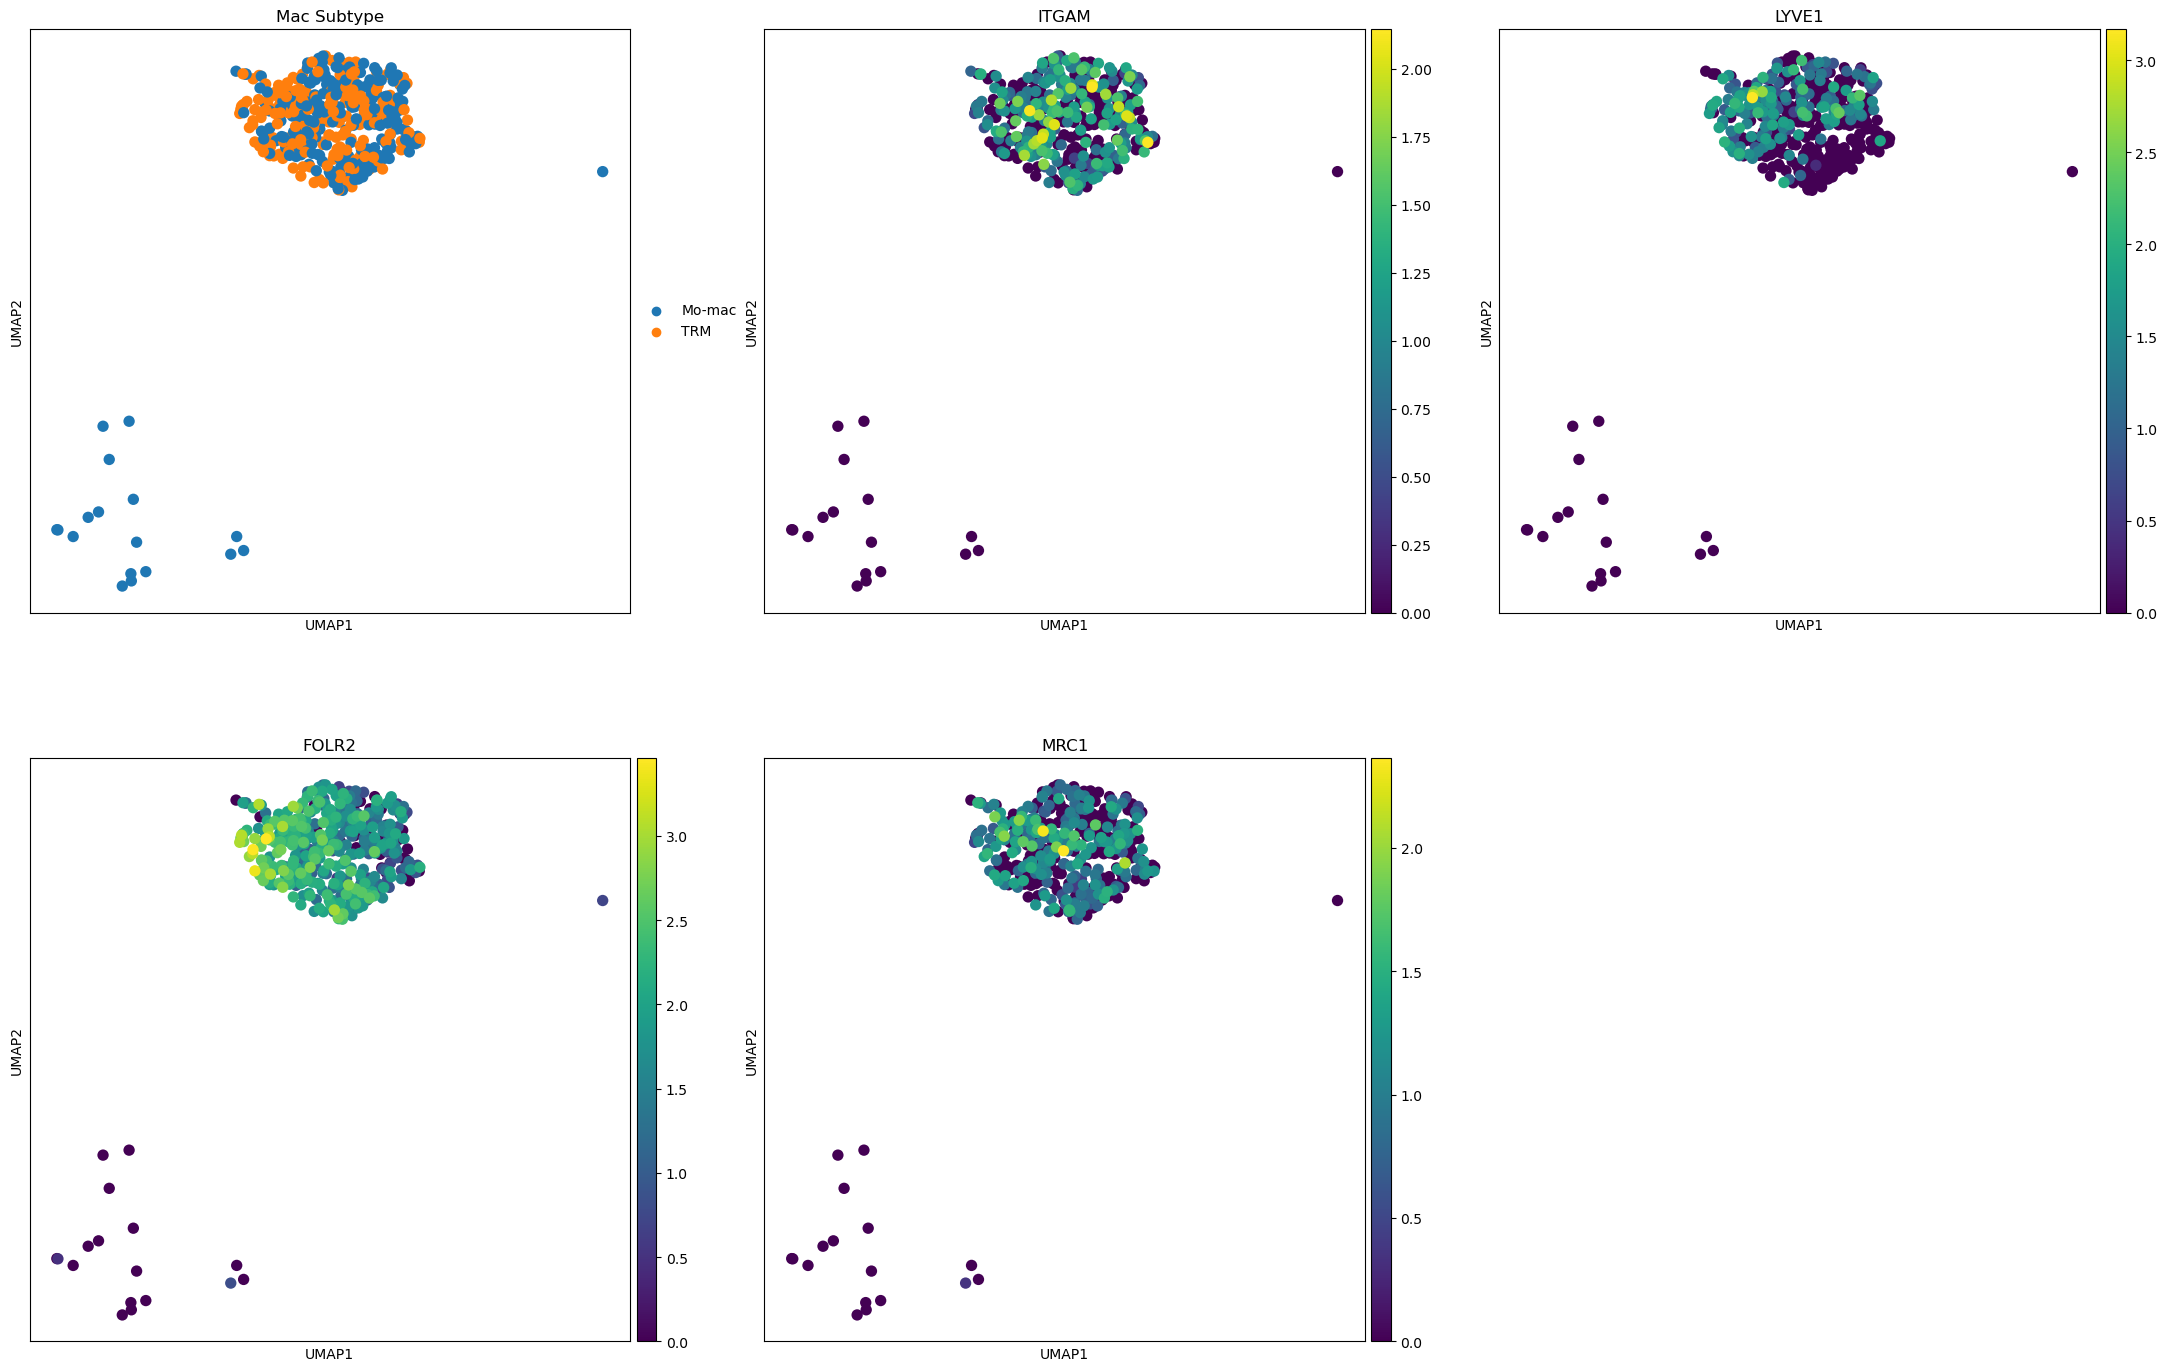

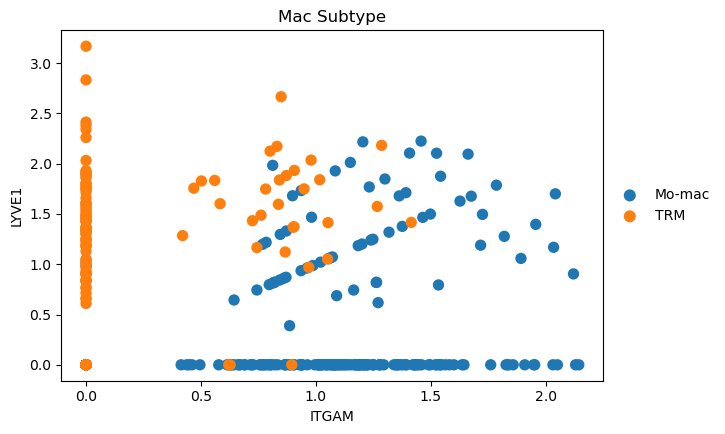

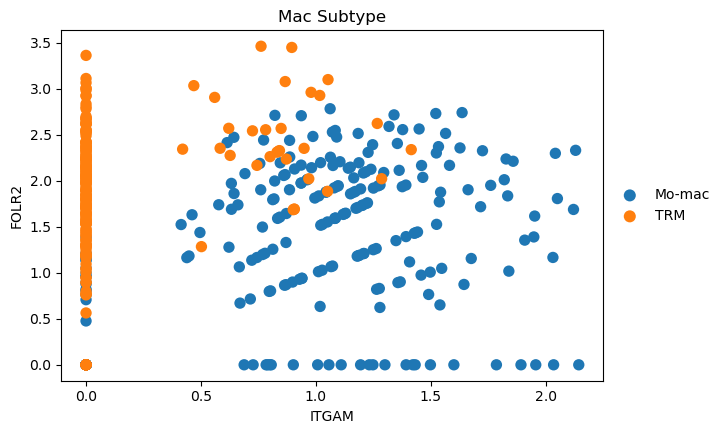

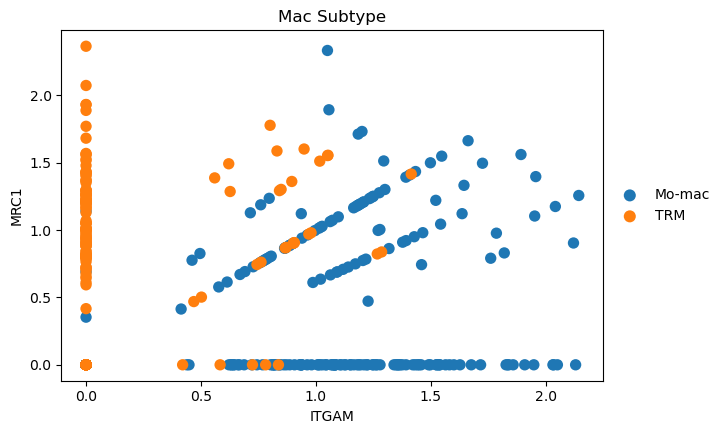

... storing 'Mac Subtype' as categorical


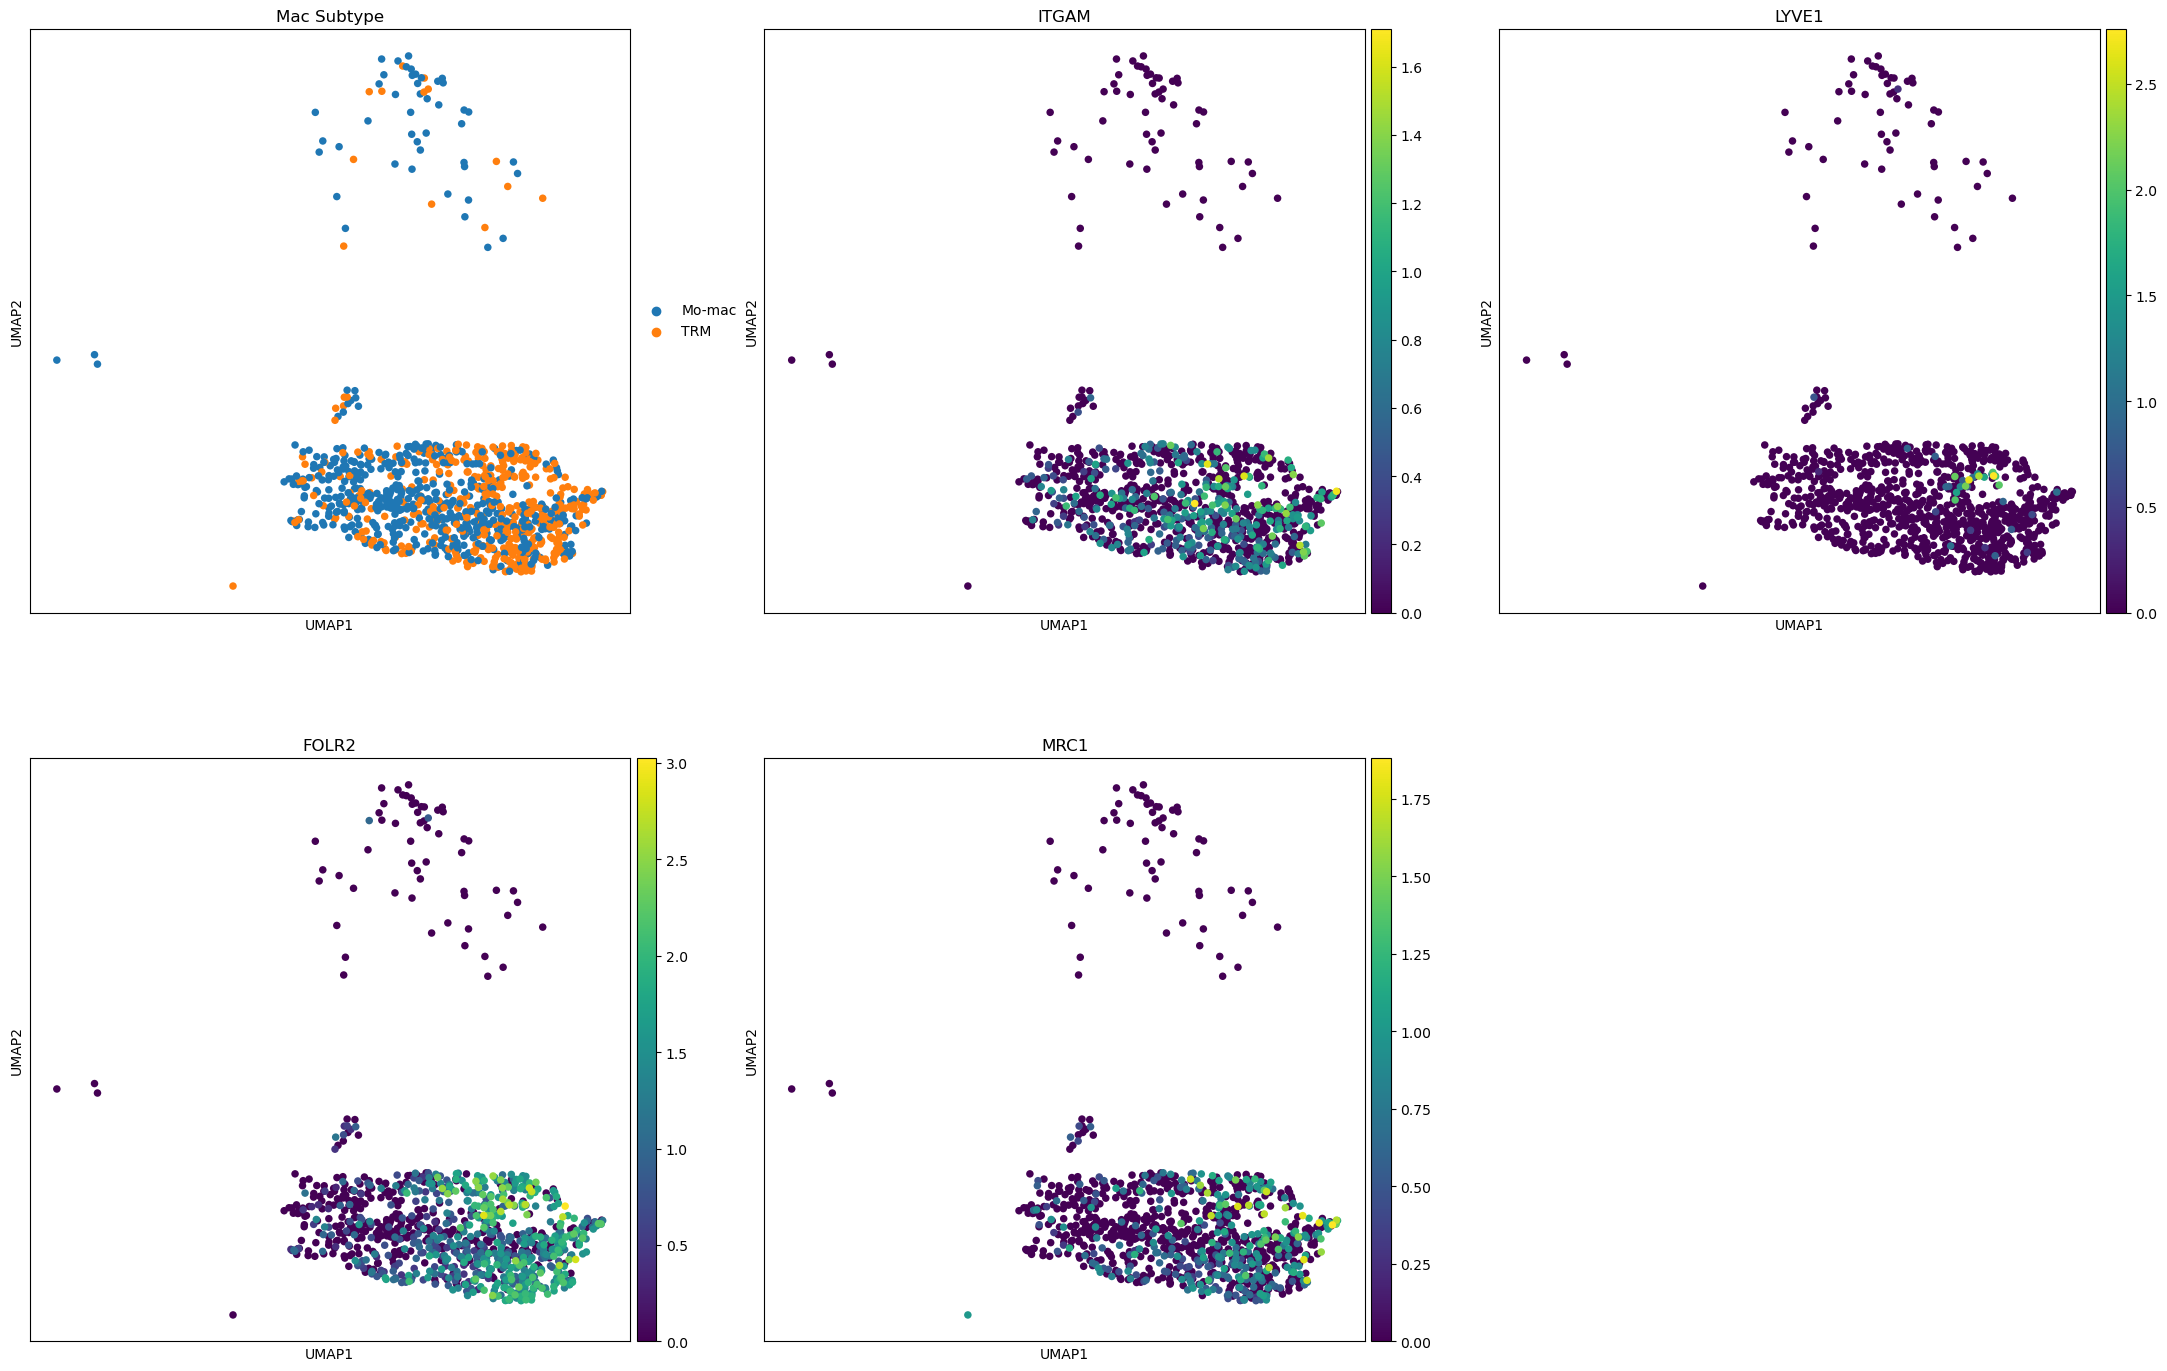

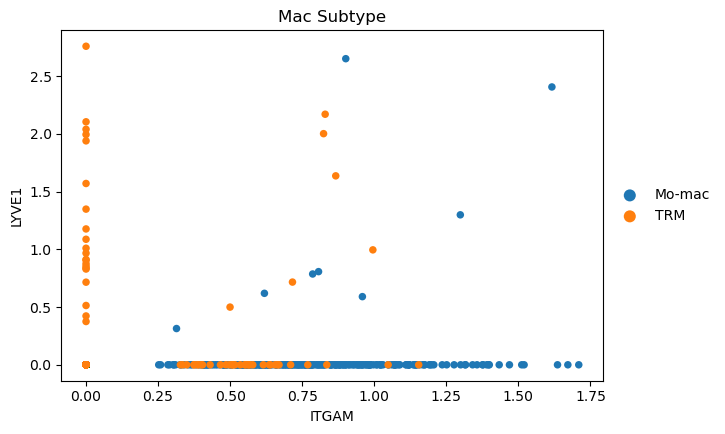

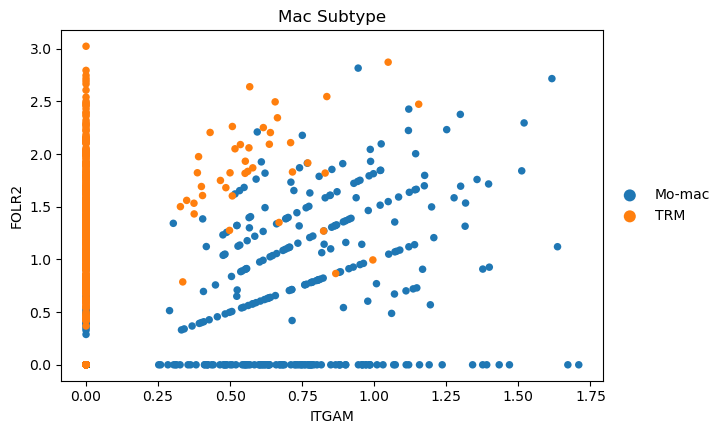

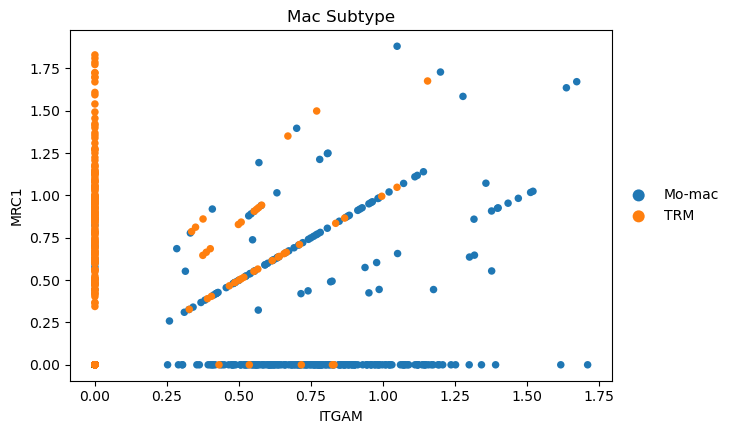

... storing 'Mac Subtype' as categorical


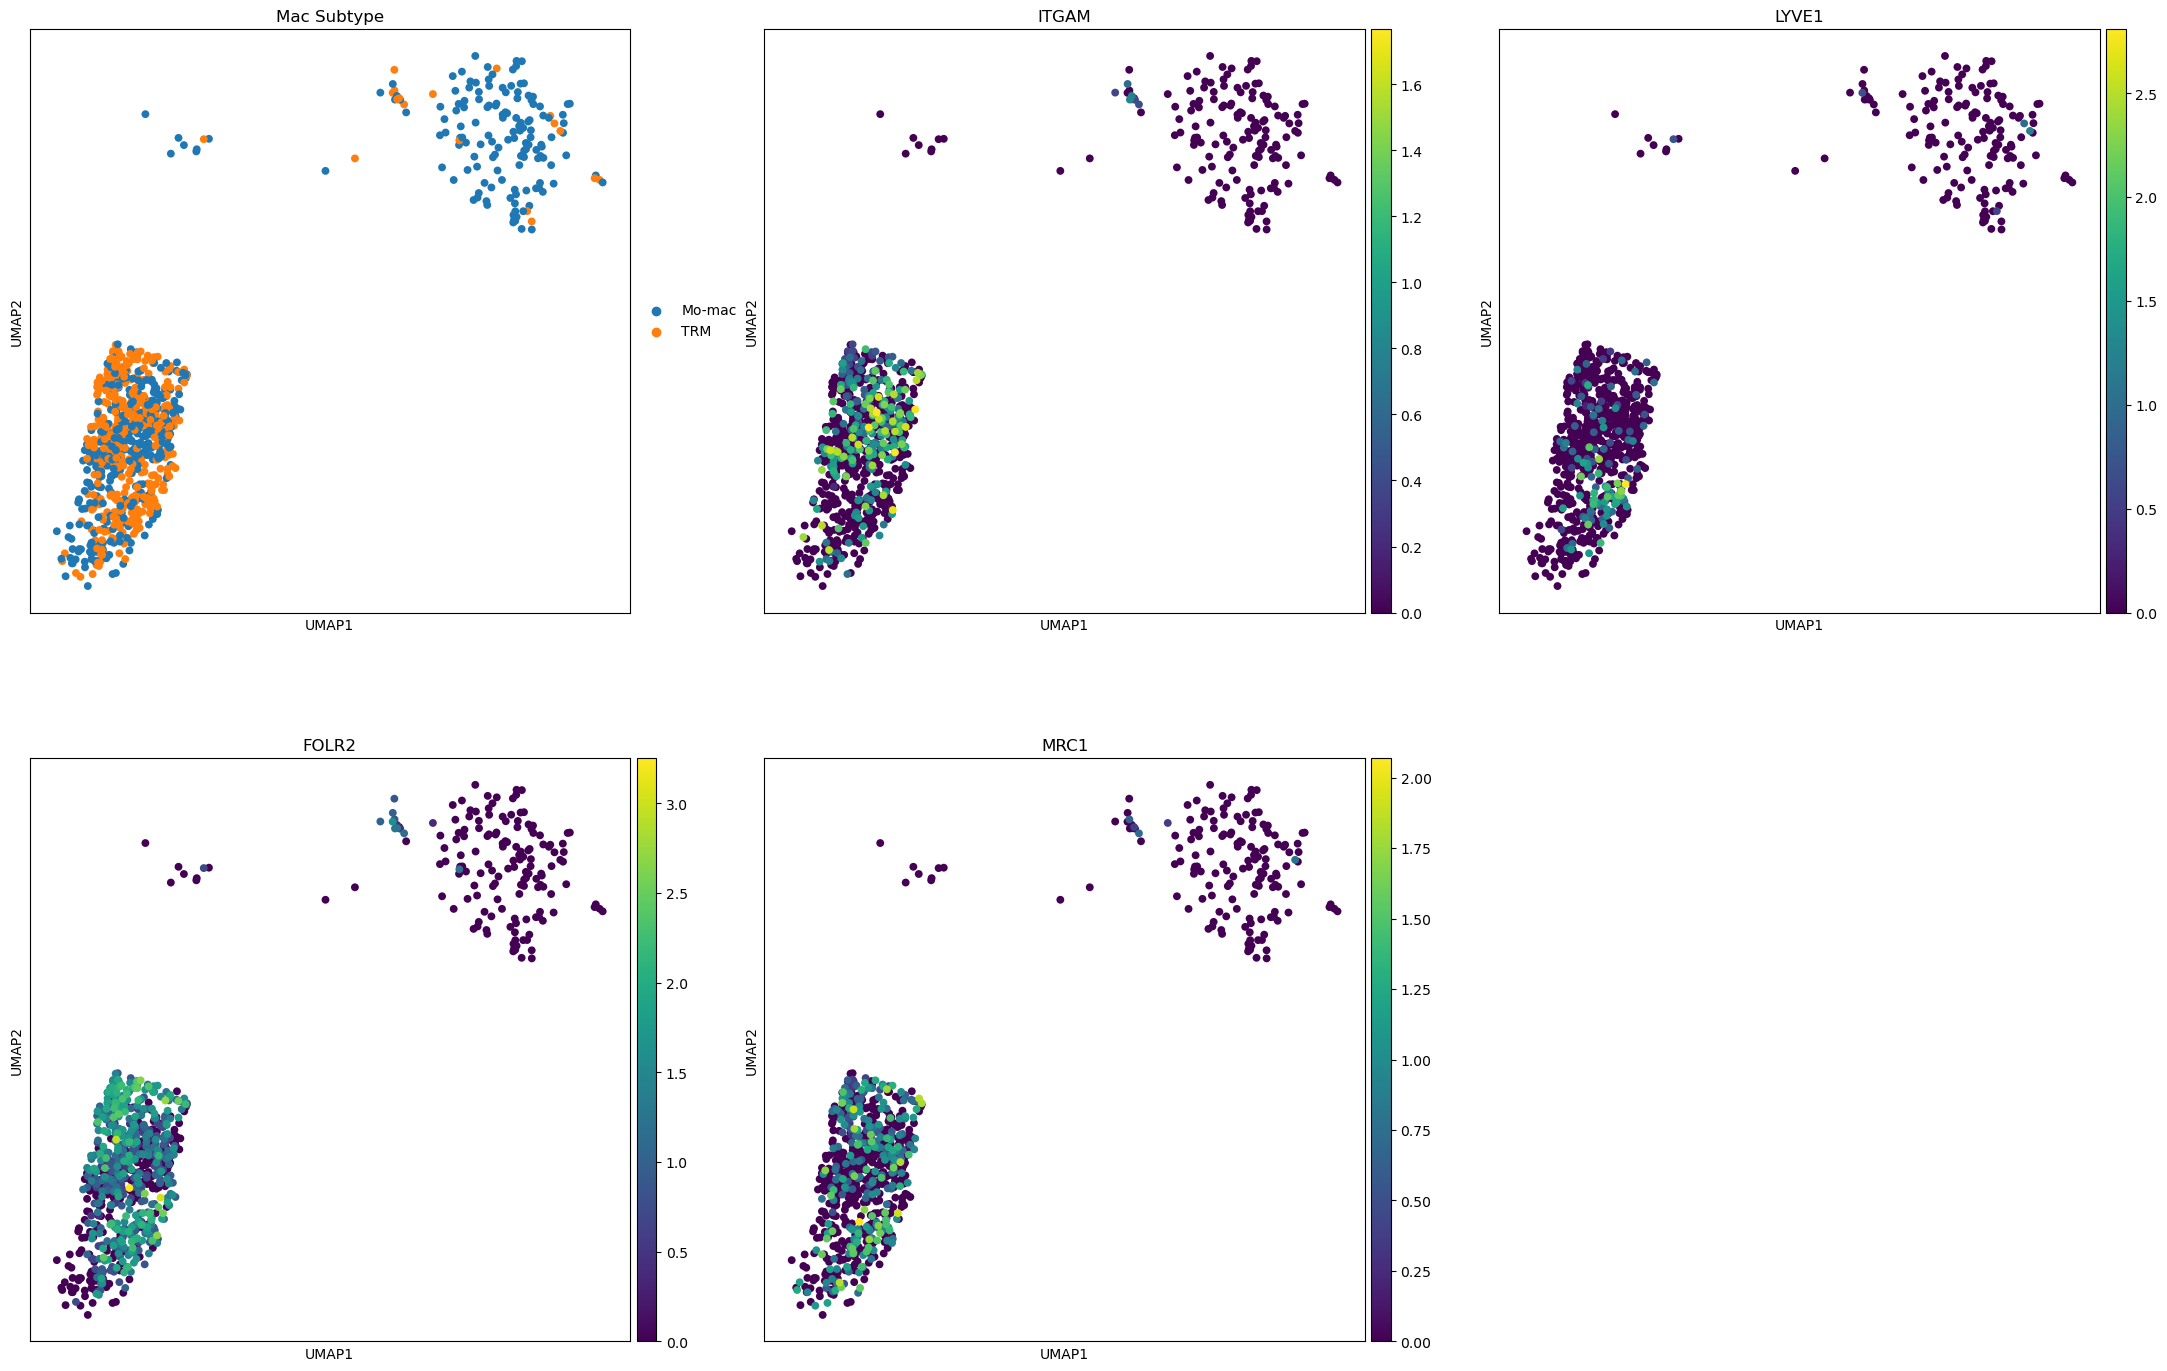

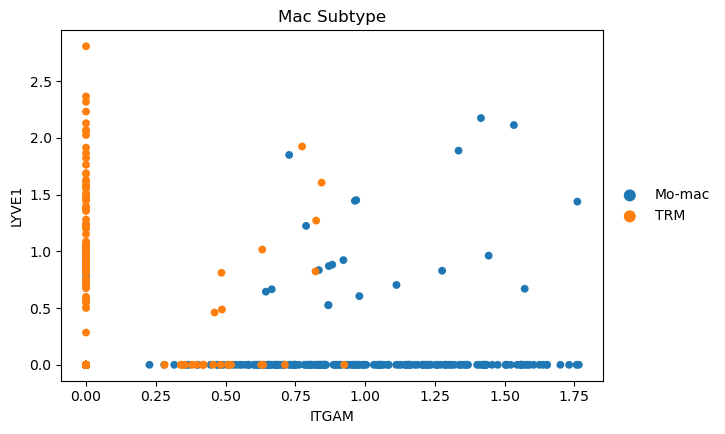

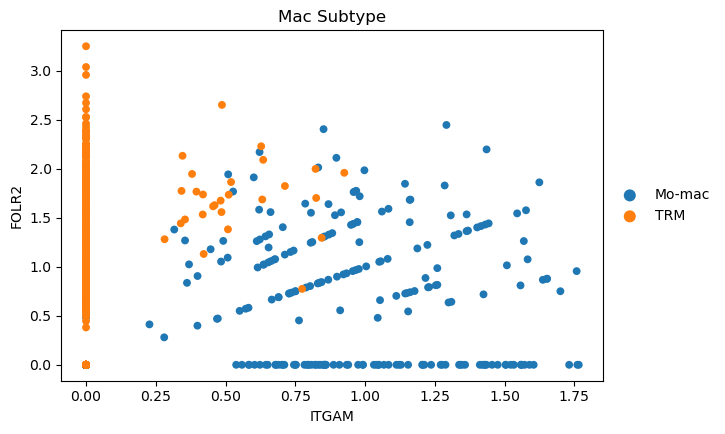

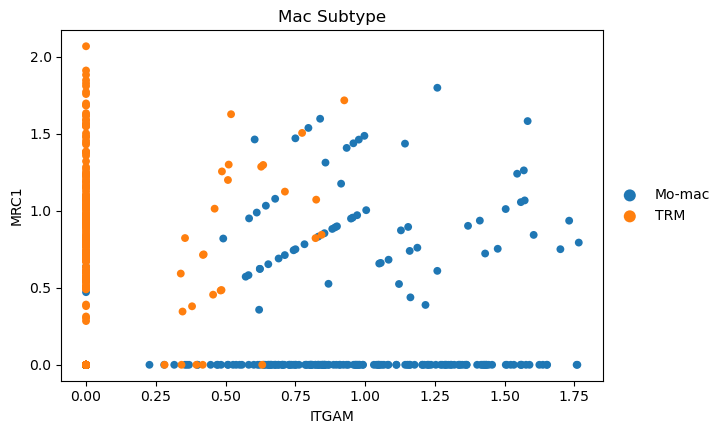

... storing 'Mac Subtype' as categorical


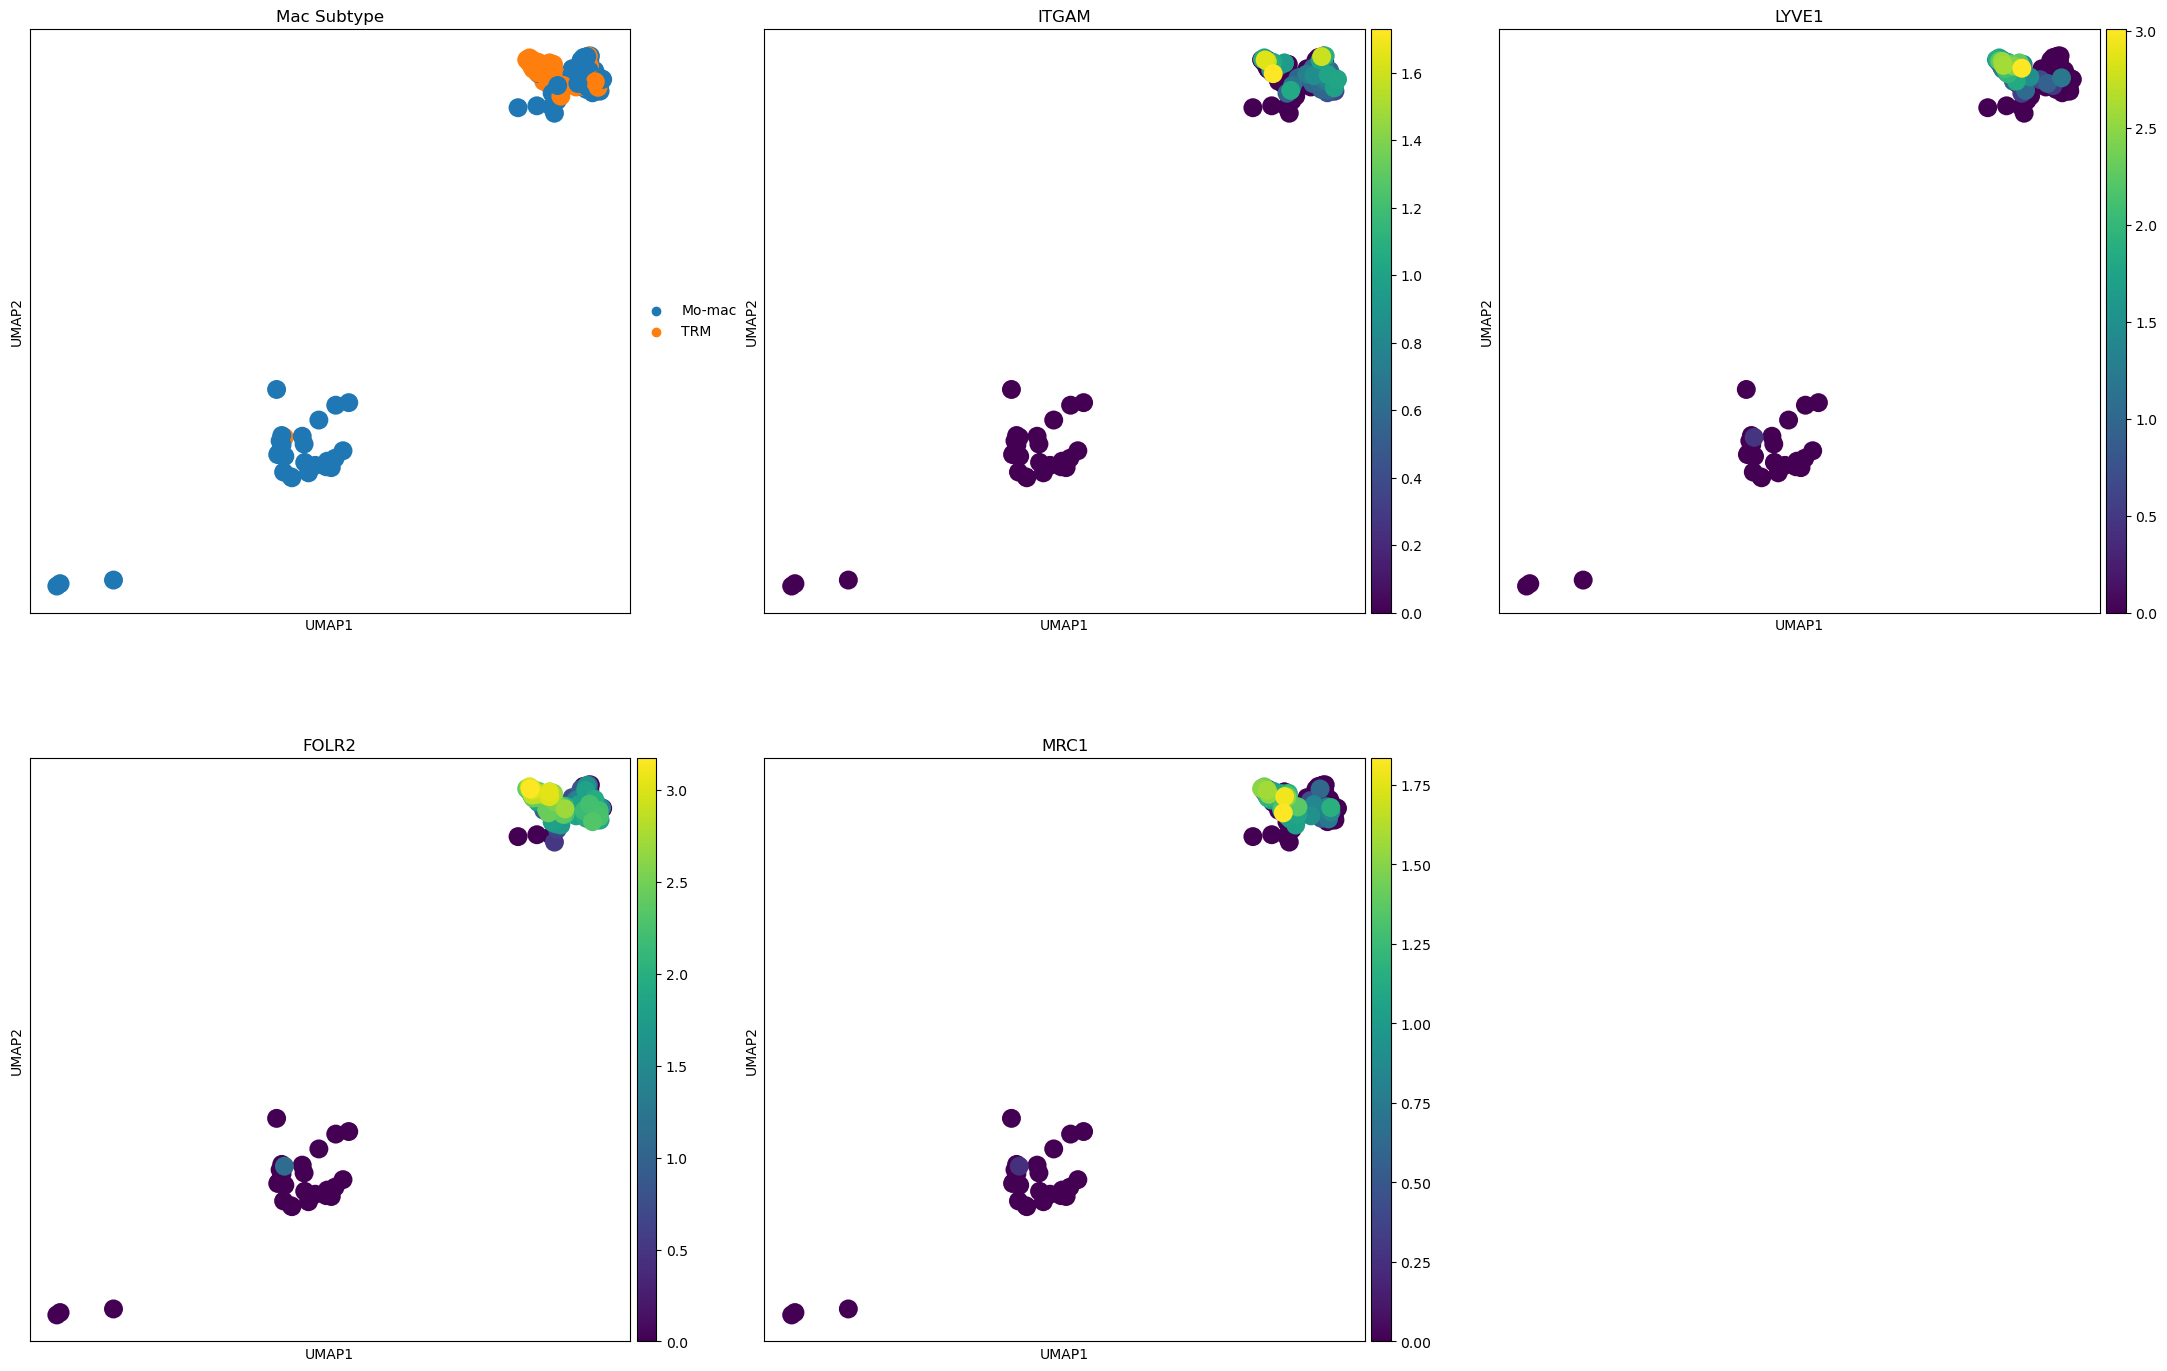

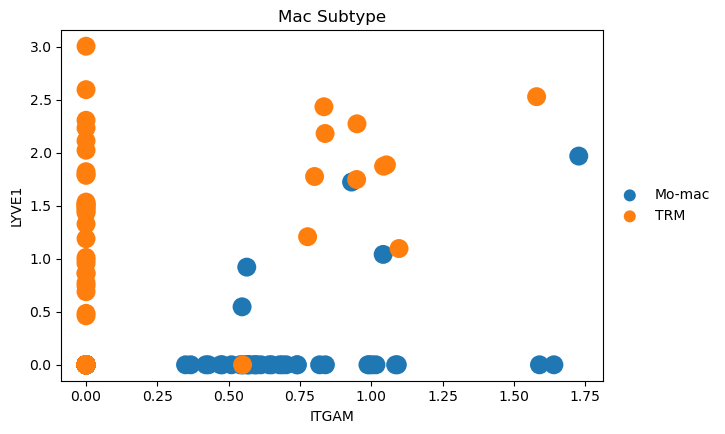

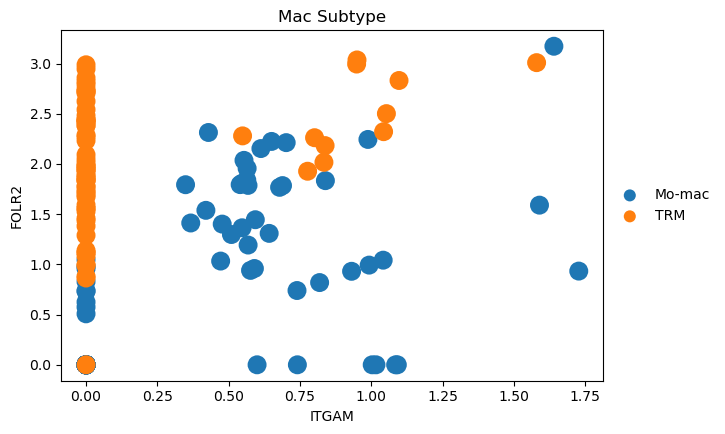

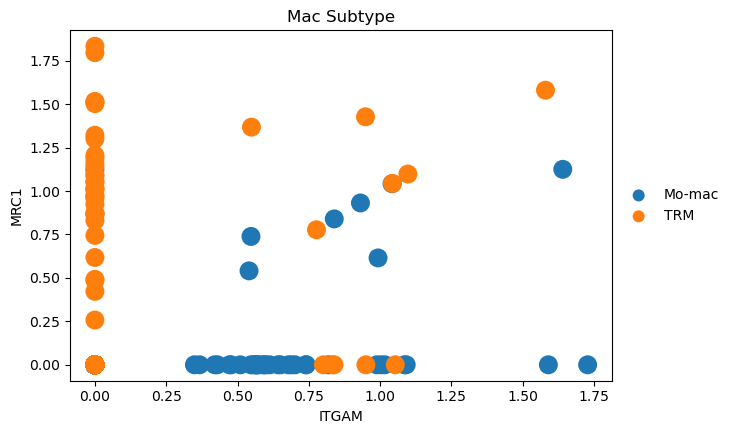

... storing 'Mac Subtype' as categorical


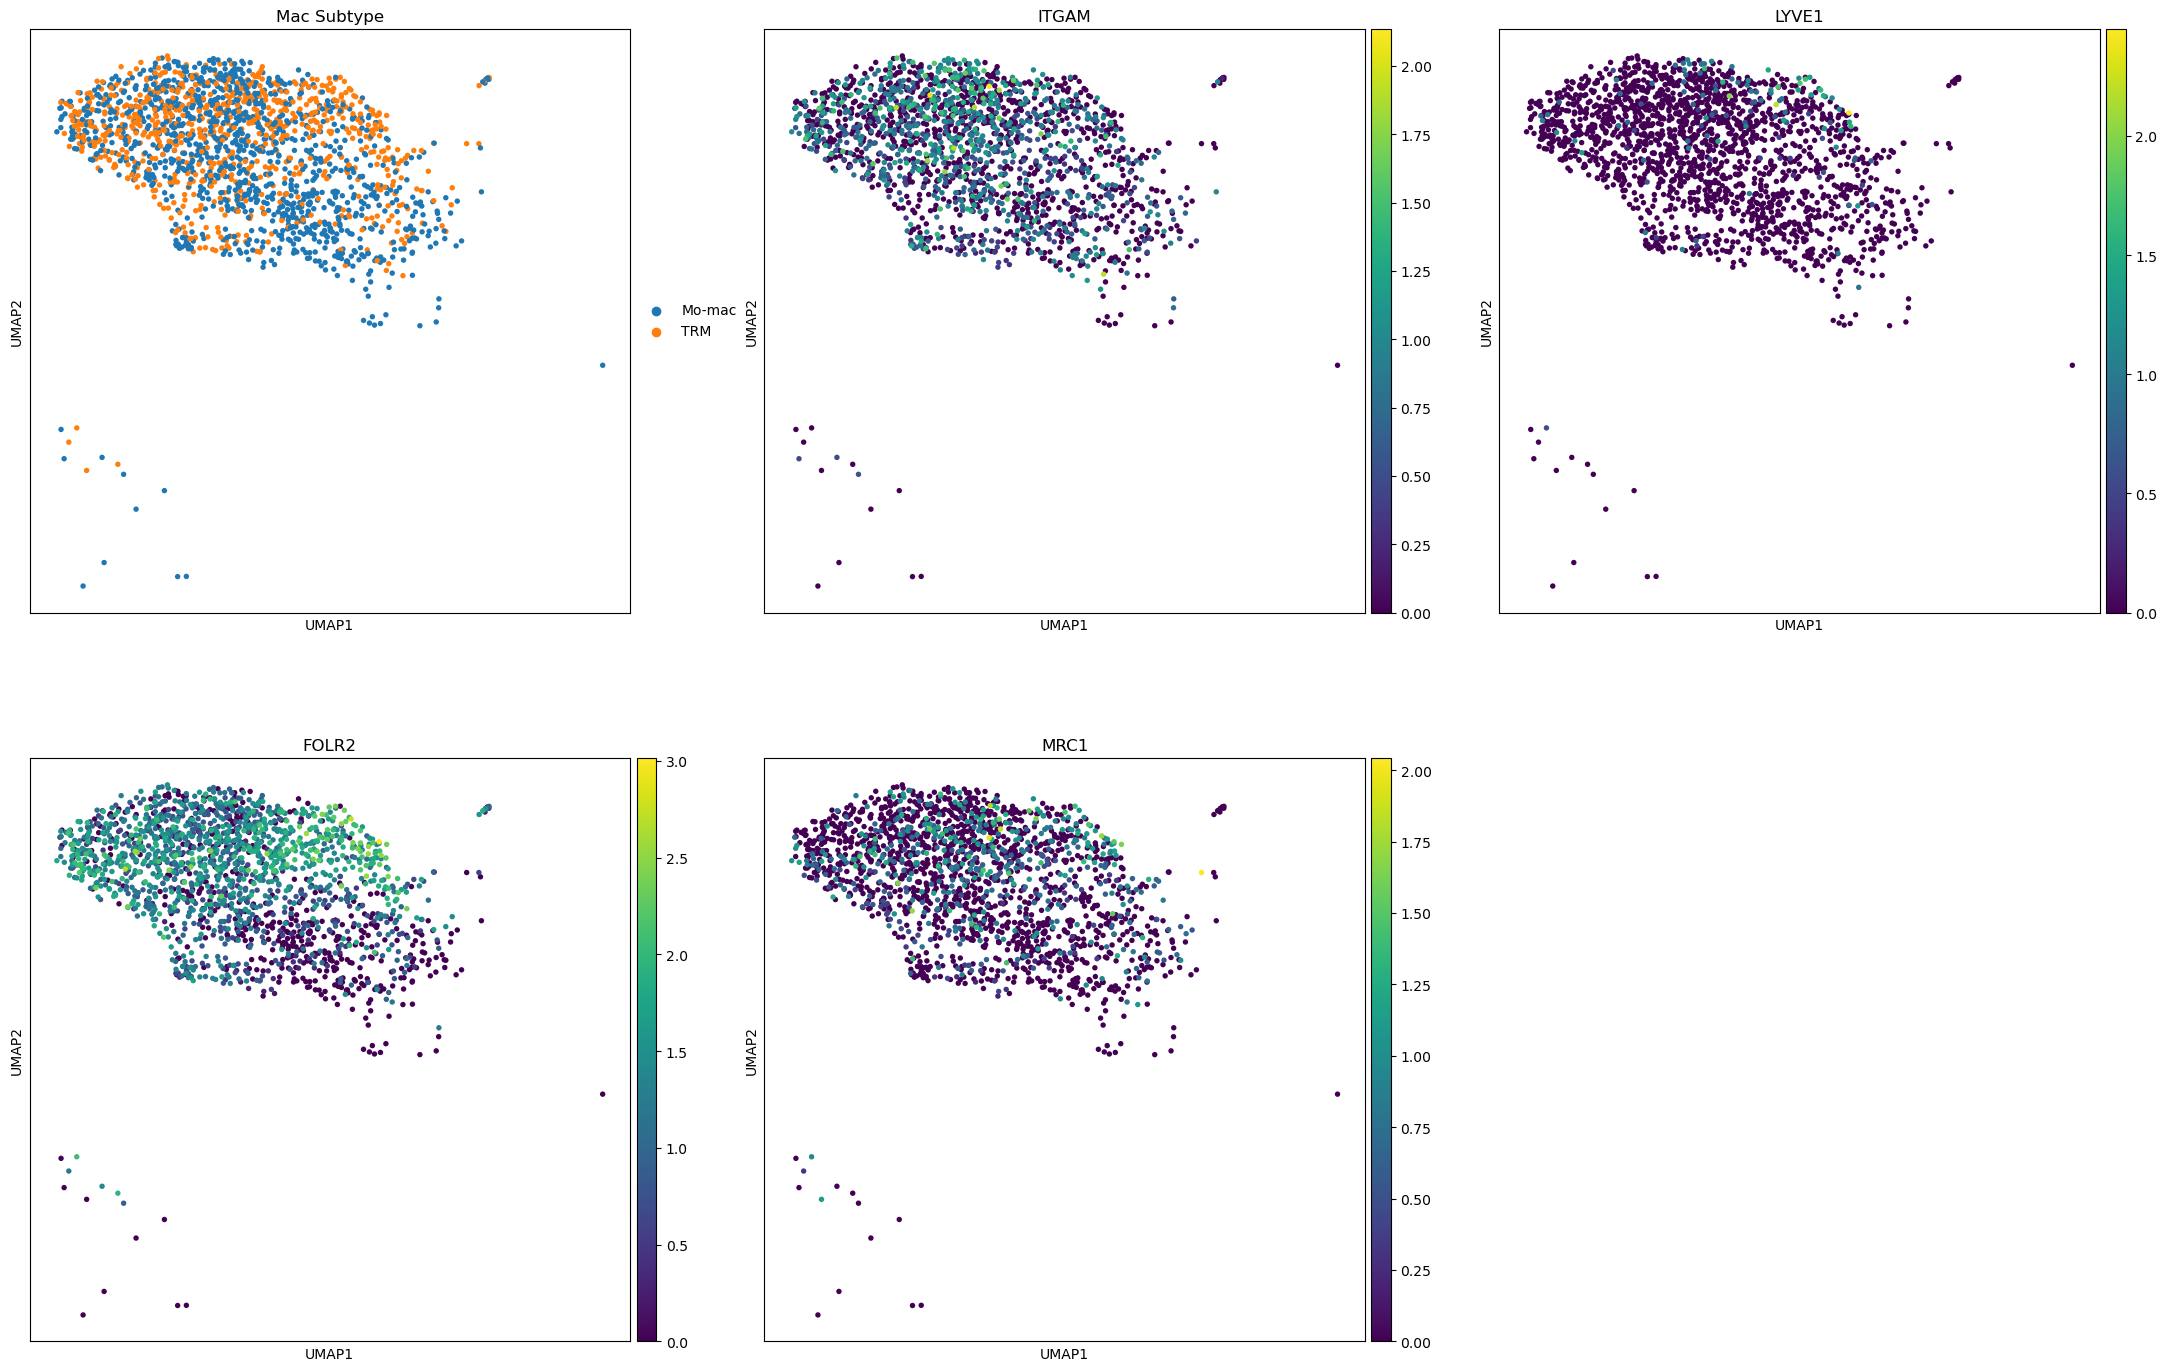

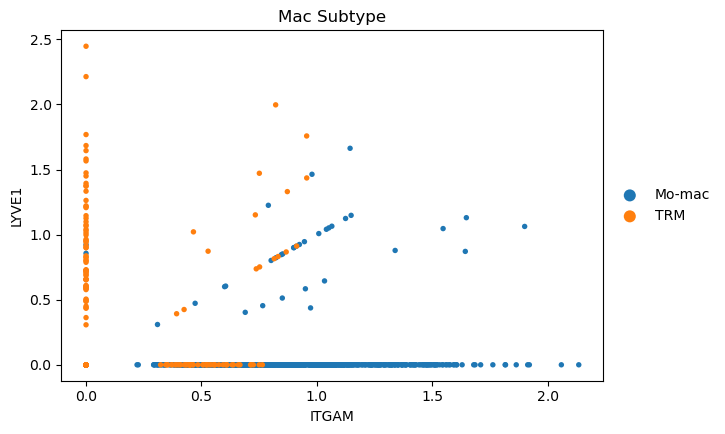

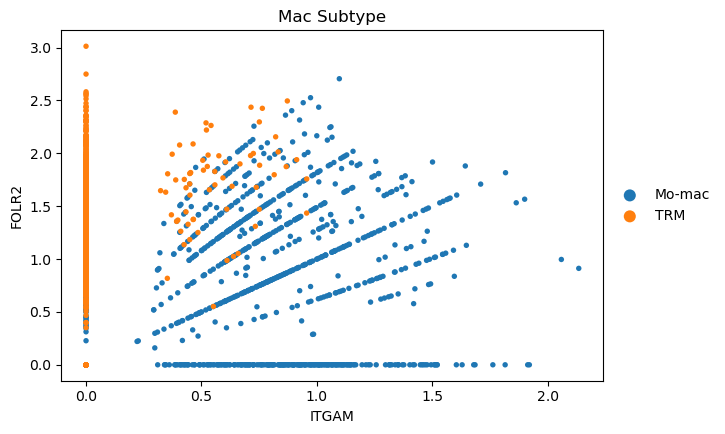

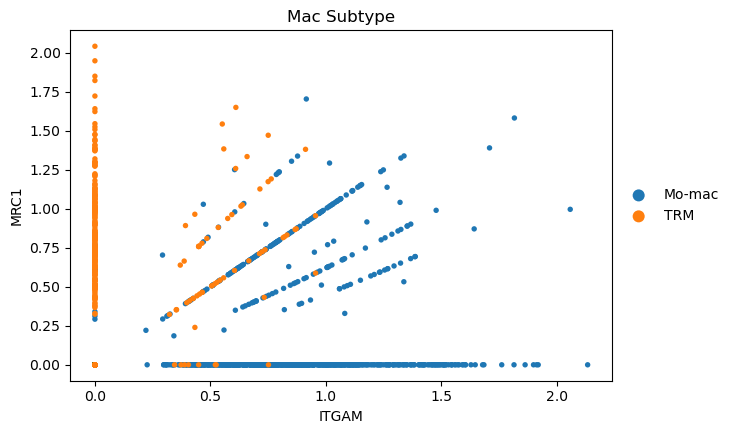

... storing 'Mac Subtype' as categorical


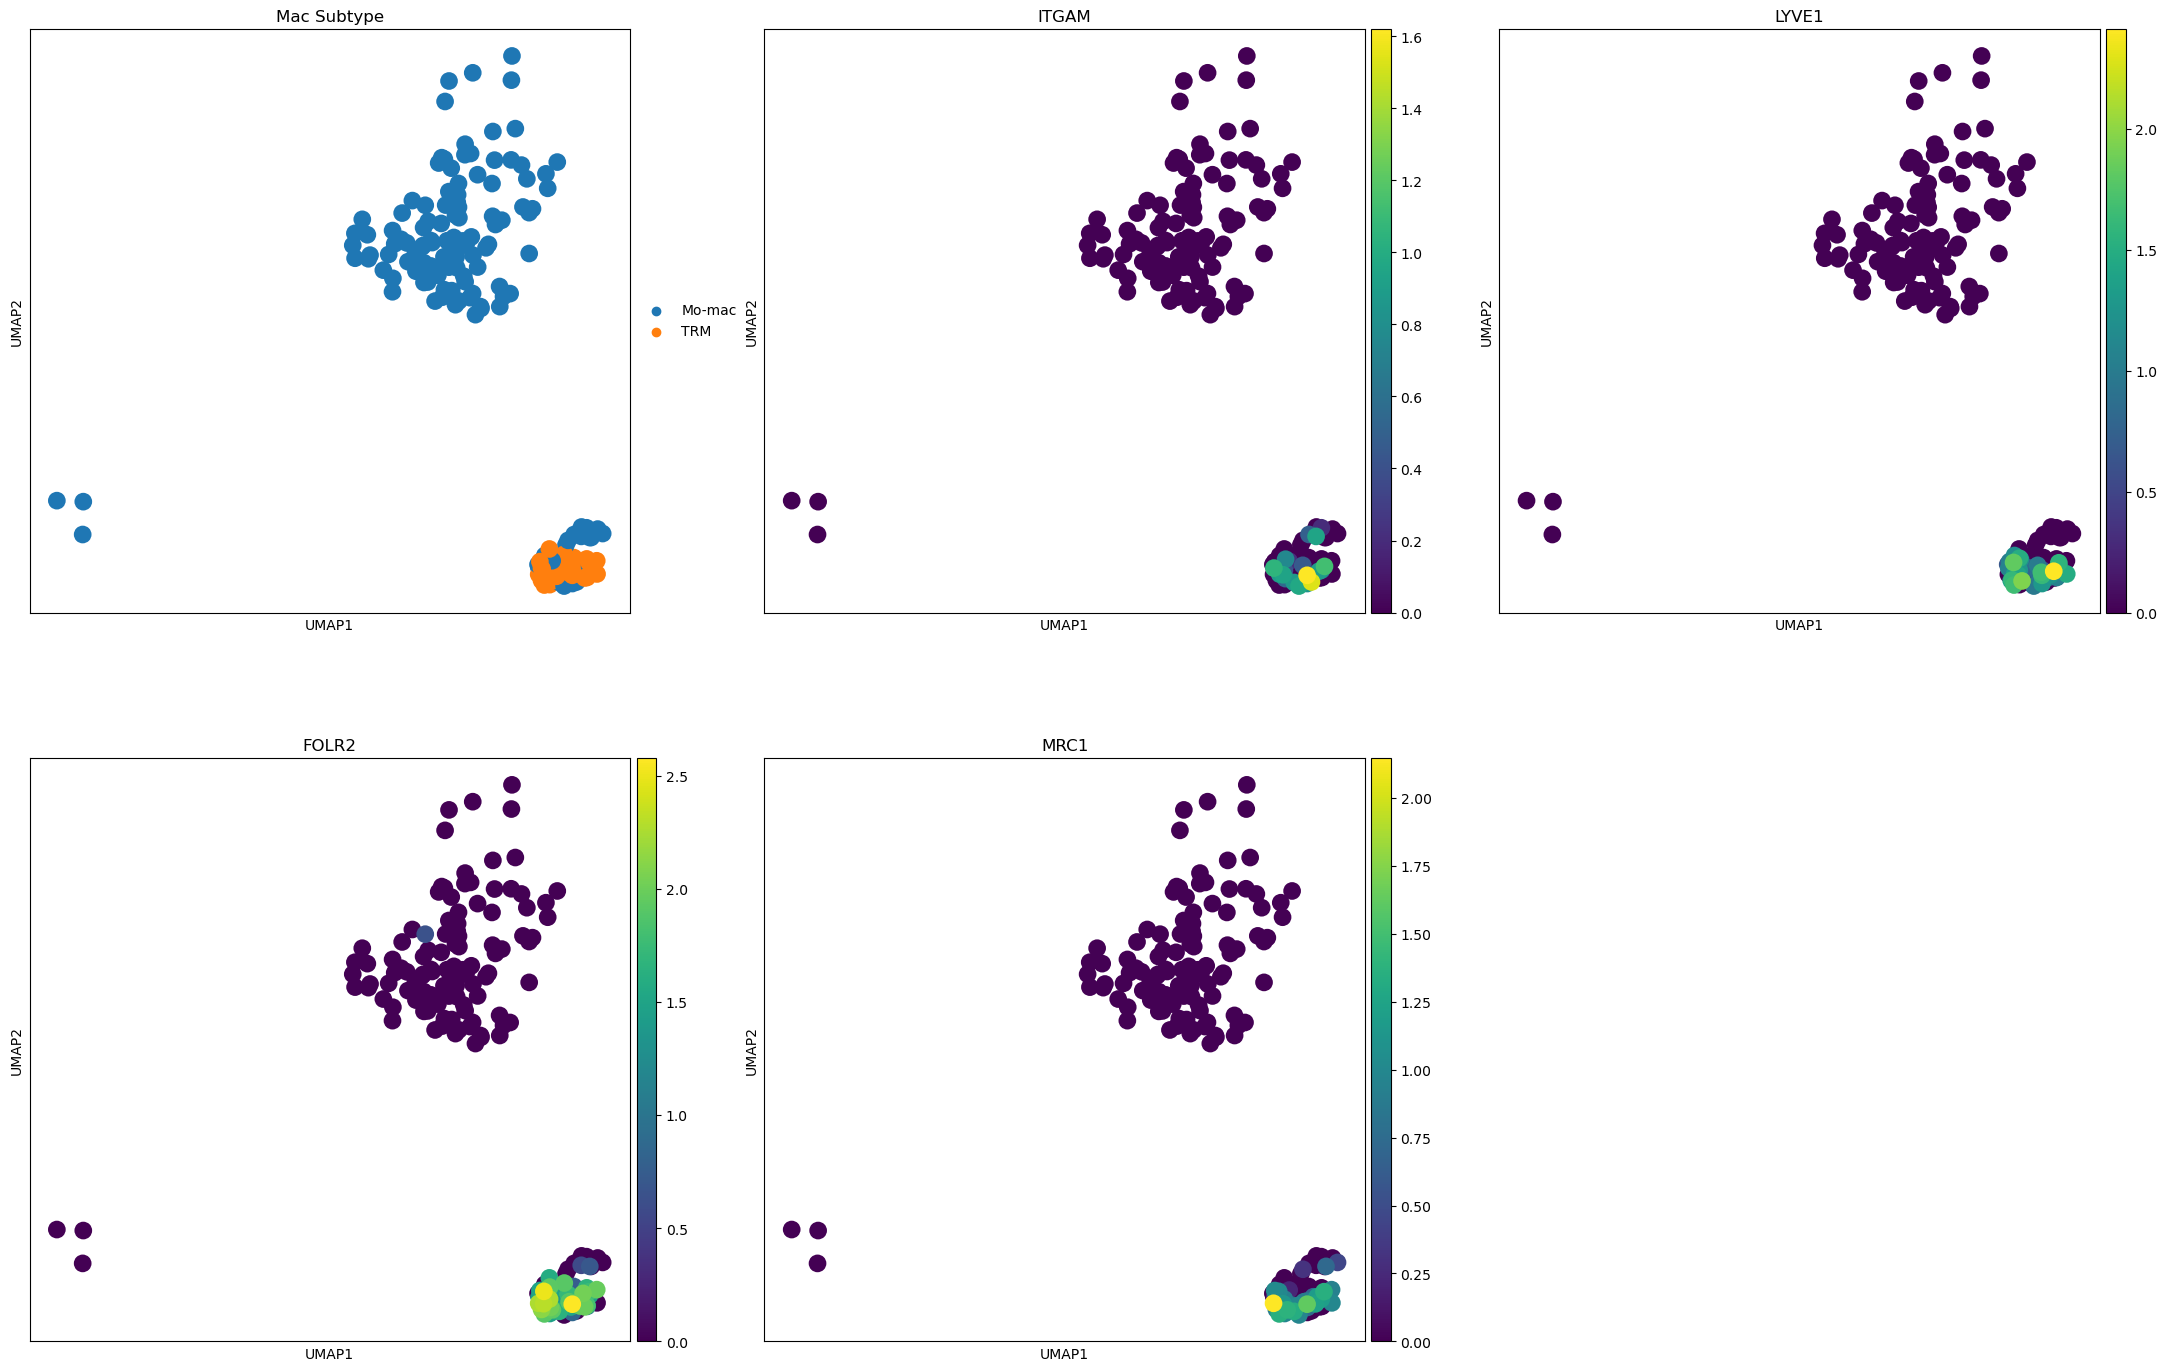

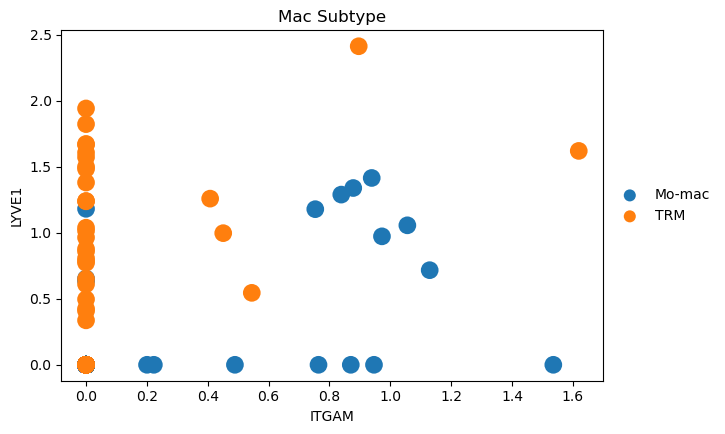

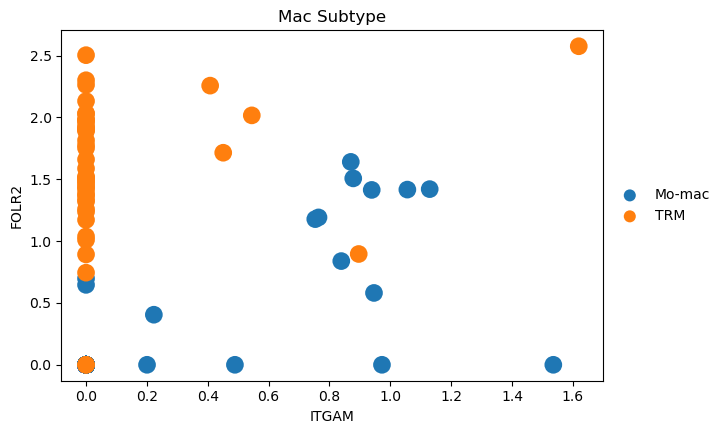

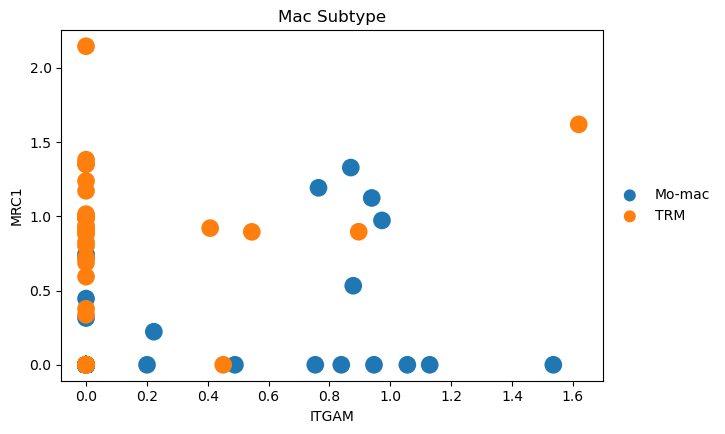

Mac Subtype      Group Sample
AAACCTGCACCCATGG-1      Mo-mac      Naive  SA220
AAACGGGTCAACGAAA-1         TRM      Naive  SA220
AAAGCAAAGTAAGTAC-1         TRM      Naive  SA220
AAATGCCGTCCCTTGT-1      Mo-mac      Naive  SA220
AACCATGTCTTGGGTA-1         TRM      Naive  SA220
...                        ...        ...    ...
TGGGAAGAGAGTACAT-1      Mo-mac  Remission  SA225
TGGGCGTGTCACACGC-1         TRM  Remission  SA225
TTAGTTCTCTGTTGAG-1      Mo-mac  Remission  SA225
TTATGCTCAACACGCC-1      Mo-mac  Remission  SA225
TTGGAACAGGTGTGGT-1      Mo-mac  Remission  SA225

[4717 rows x 3 columns]

In [9]:
marker_genes_dict = {
    "Mo-mac": ["ITGAM"],
    "TRM": ["LYVE1", "FOLR2", "MRC1"],
}

all_macs = []
for adata in ads:
    mac_adata = adata[adata.obs["cell_type"] == "Macrophages"].copy()

    for celltype, genes in marker_genes_dict.items():
        sc.tl.score_genes(
            mac_adata,
            gene_list=genes,
            score_name=f"{celltype}_score"
        )

    score_cols = [f"{ct}_score" for ct in marker_genes_dict.keys()]

    mac_adata.obs["Mac Subtype"] = (
        mac_adata.obs[score_cols]
        .idxmax(axis=1)
        .str.replace("_score", "")
    )

    with plt.rc_context({"figure.figsize": (8, 8)}):
        sc.pl.umap(mac_adata, color=["Mac Subtype","ITGAM", "LYVE1", "FOLR2", "MRC1"], ncols=3)
    
    
    sc.pl.scatter(mac_adata,
             x="ITGAM",
             y="LYVE1",
            color="Mac Subtype"
             )
    sc.pl.scatter(mac_adata,
         x="ITGAM",
         y="FOLR2",
            color="Mac Subtype"
         )
    sc.pl.scatter(mac_adata,
         x="ITGAM",
         y="MRC1",
            color="Mac Subtype"
         )
    all_macs.append(mac_adata)

all_mac_data = sc.concat(all_macs, merge="same", join="inner")
mac_df = sc.get.obs_df(all_mac_data, keys=["Mac Subtype", "Group", "Sample"])
display(mac_df)
mac_df.to_csv("../Data/macrophage_subtype_designation.csv")

In [10]:
mac_df["Mac Subtype"].value_counts()

Mac Subtype
Mo-mac    2755
TRM       1962
Name: count, dtype: int64

In [6]:
adata = sc.concat(ads, merge="same", join="inner")
adata.obs_names_make_unique()
#adata.X.dtype = np.int64
adata.X = adata.X.toarray()
adata.X[np.isnan(adata.X)] = 0 
display(adata)

AnnData object with n_obs × n_vars = 21754 × 13454
    obs: 'Group', 'Sample', 'cell_type', 'leiden'
    obsm: 'X_pca', 'X_umap'

In [7]:
sets = [set(x.var_names) for x in ads]
union = list(sets[0].intersection(*sets[1:]))
print("The total number of genes included in these samples is: ", len(union))

The total number of genes included in these samples is:  13454


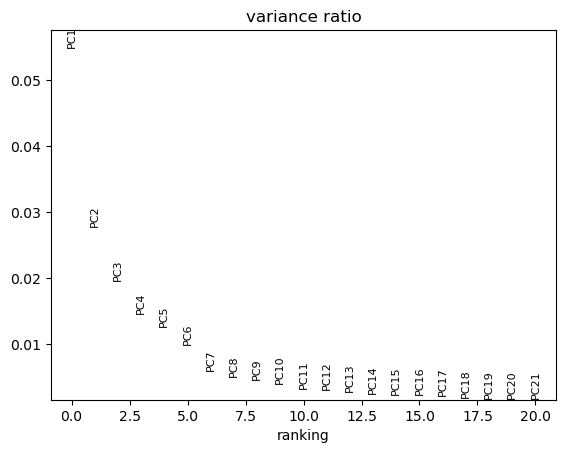

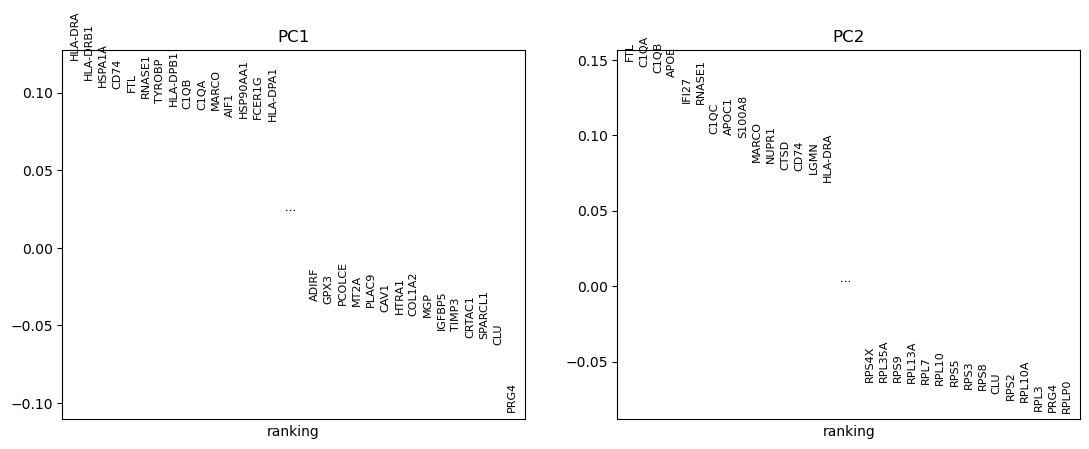

In [8]:
# select only the macrophages for gene expression analysis
adata = adata[adata.obs["cell_type"] == "Macrophages"]
sc.pp.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=20)
sc.pl.pca_loadings(adata, components=(1, 2), include_lowest=True)

In [11]:
# process.extractOne returns the best match and its score
best_match, score = process.extractOne("MRC1", adata.var_names)
print(best_match)

MRC1


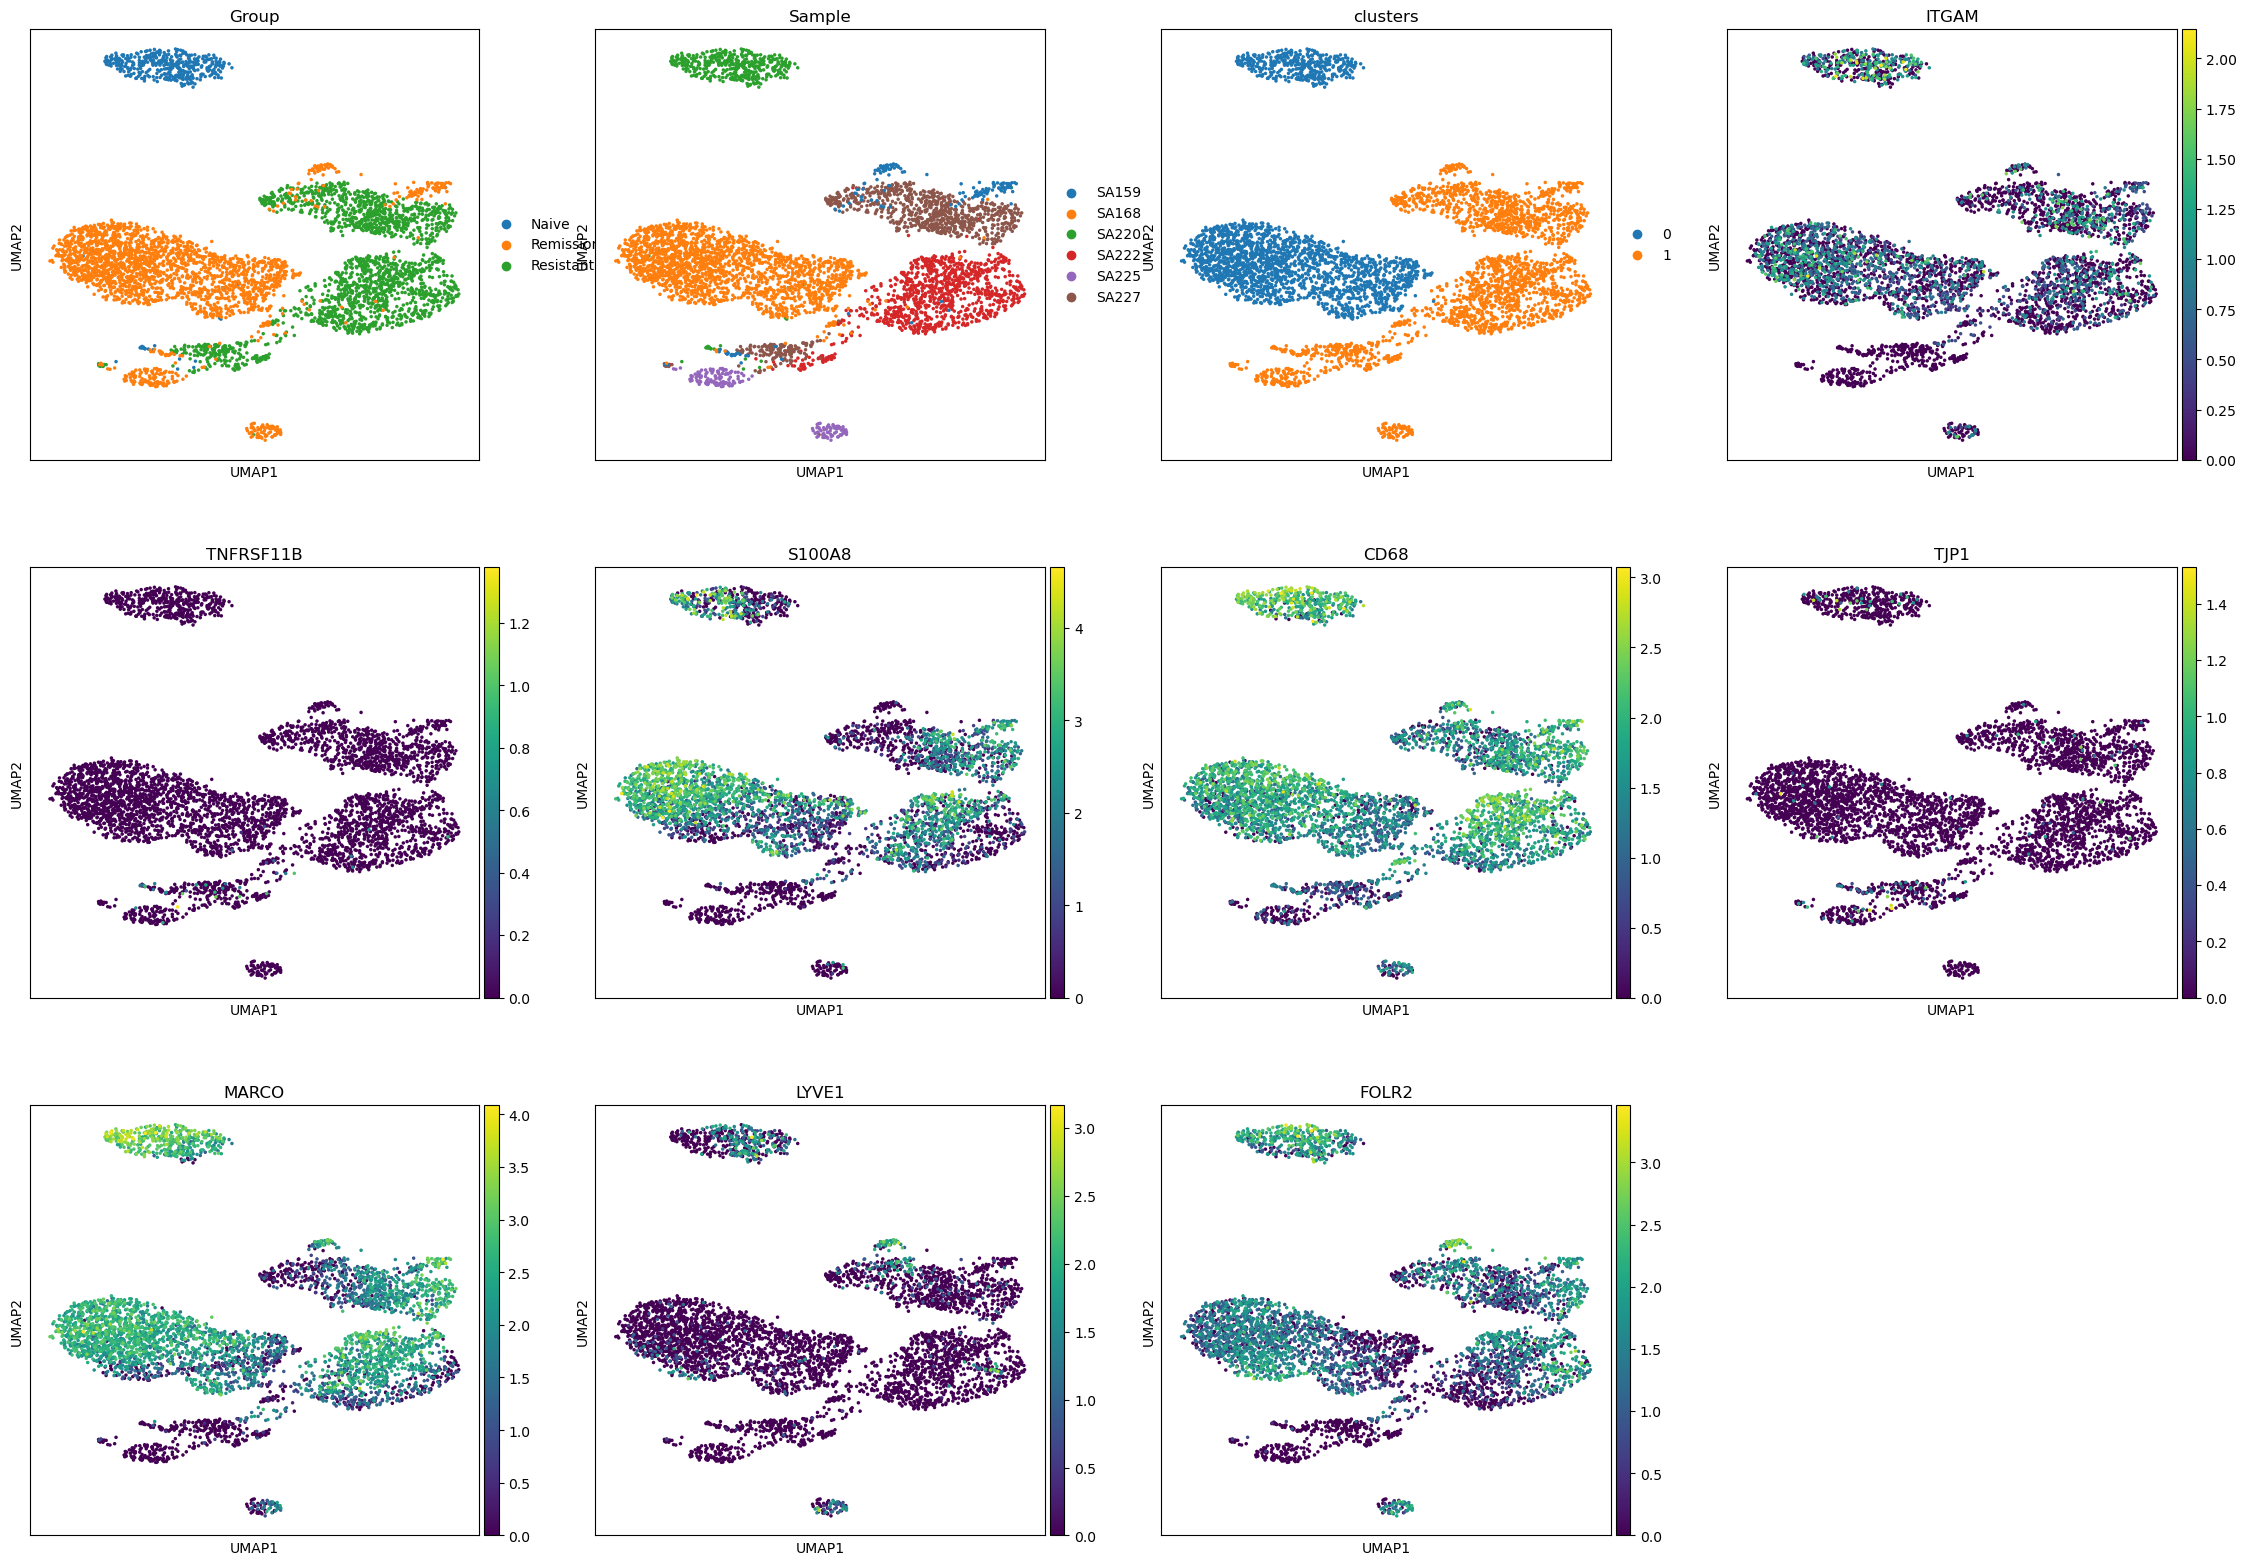

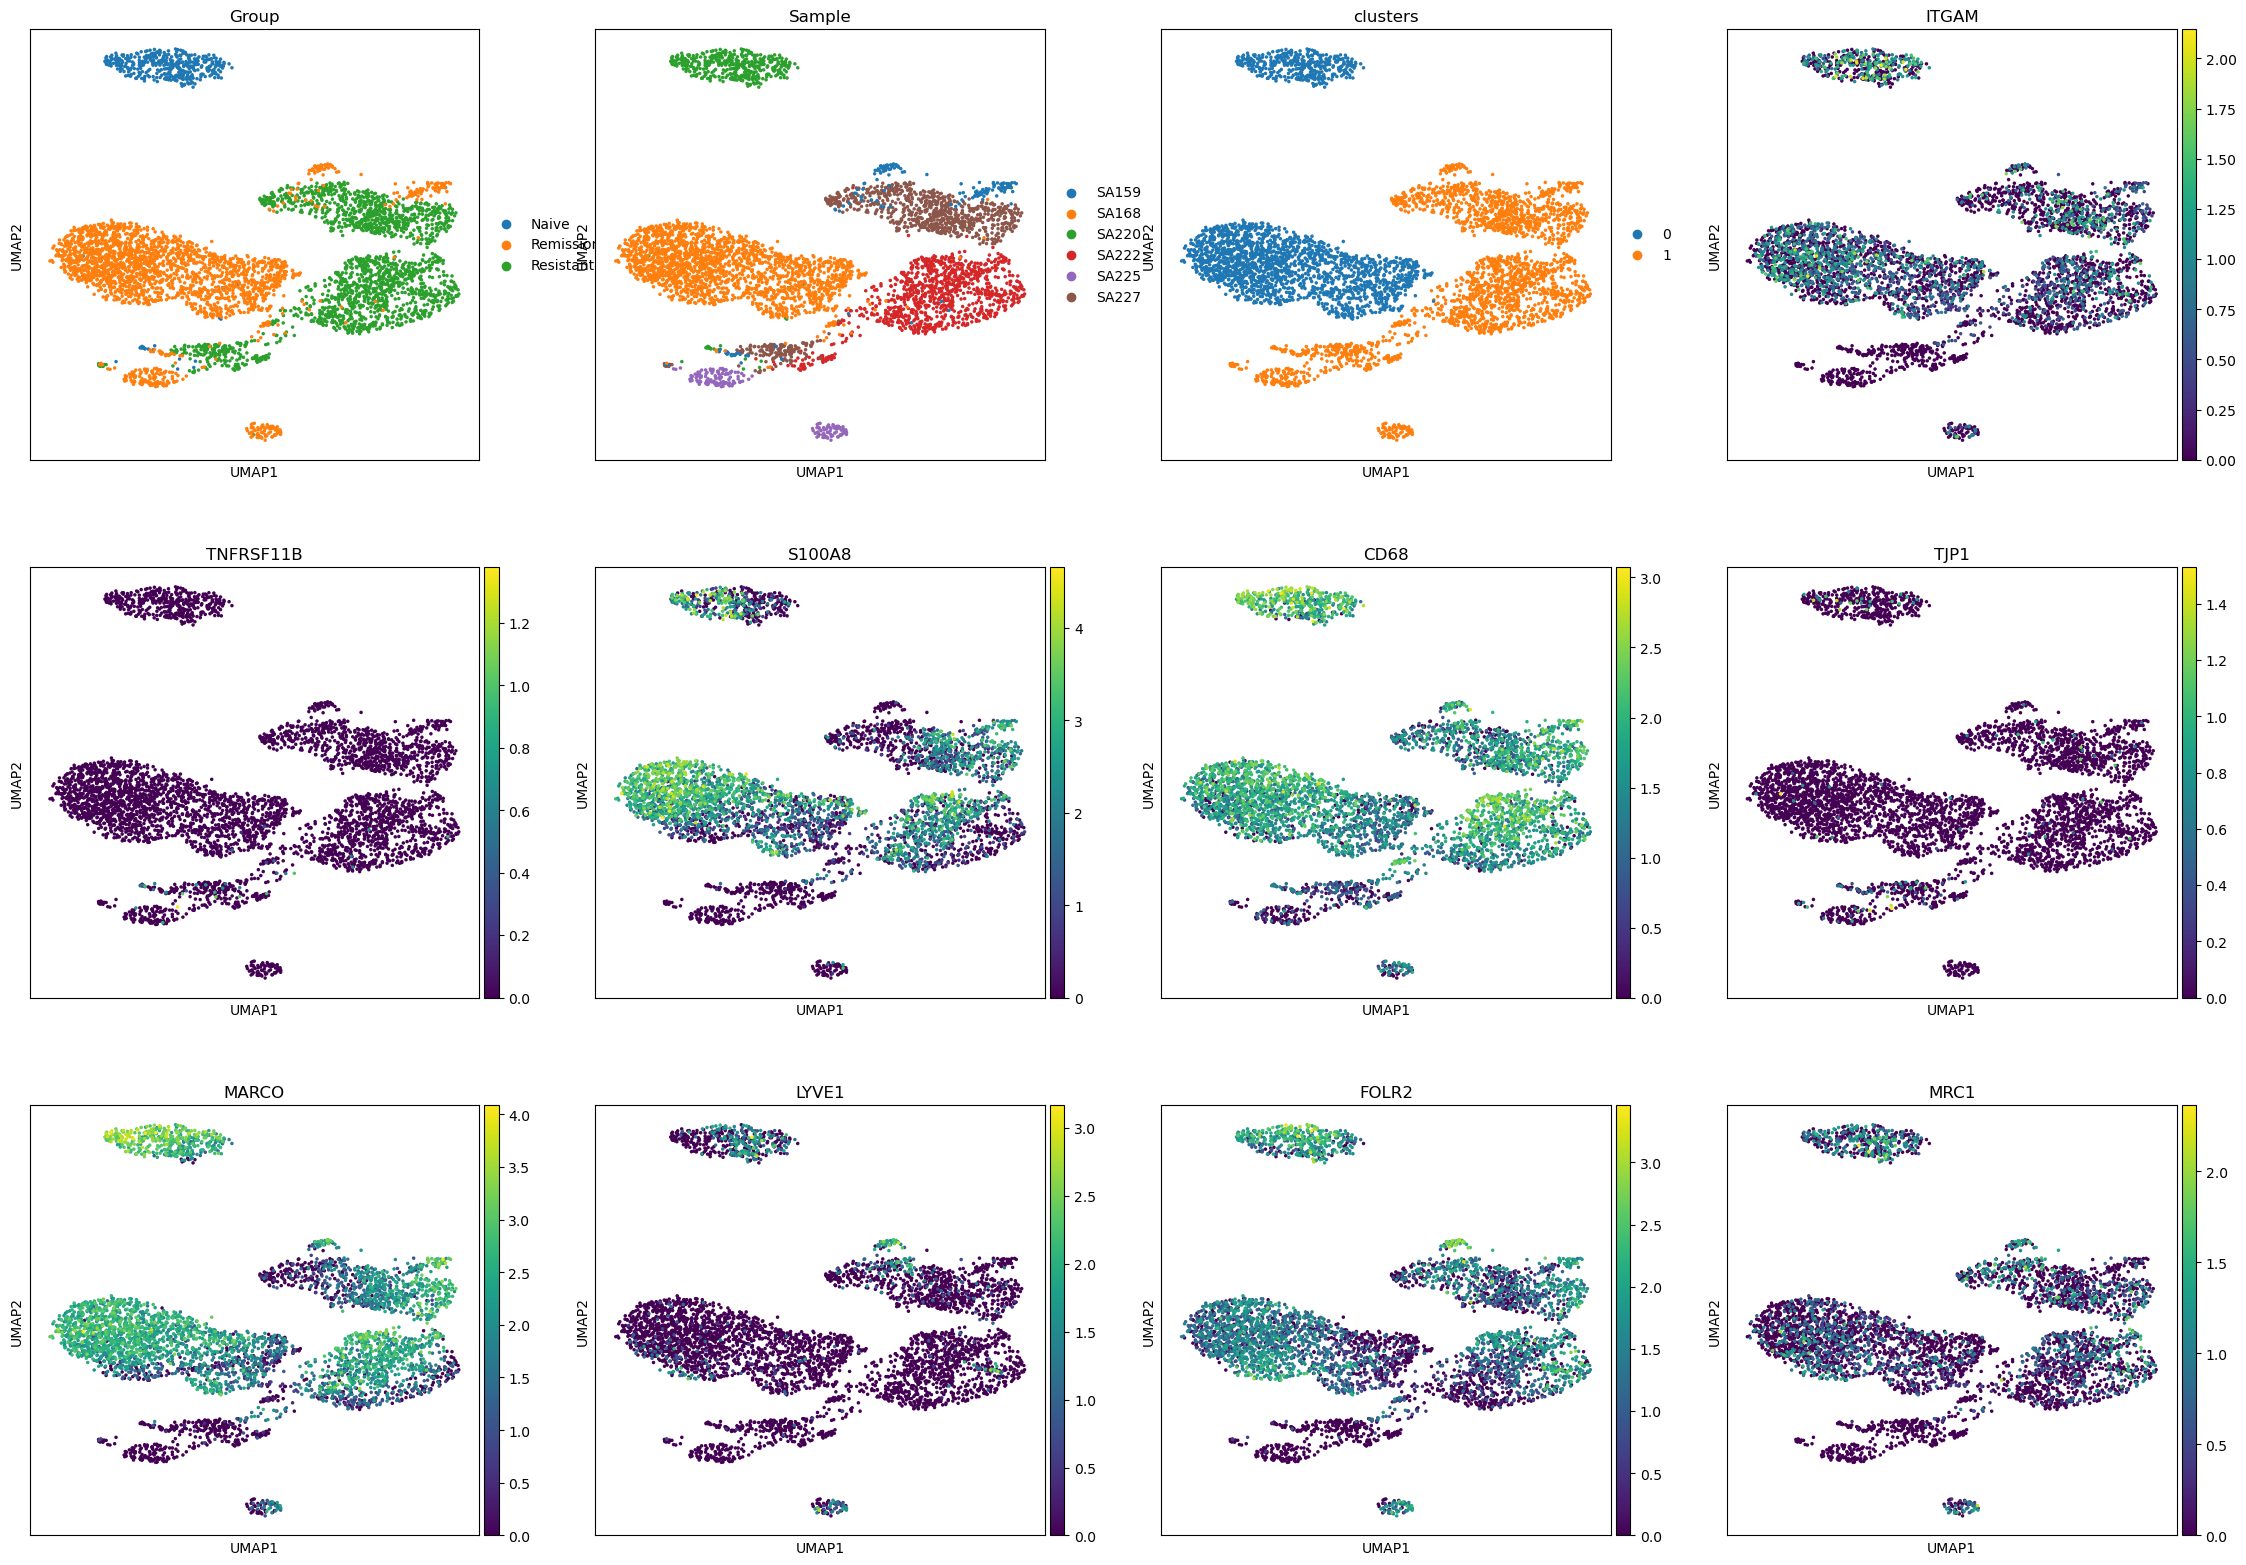

In [12]:
sc.pp.neighbors(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

sc.tl.leiden(
    adata,
    key_added="clusters",
    resolution=0.02,
    n_iterations=2,
    flavor="igraph",
    directed=False,
);

with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(adata, color=["Group", "Sample", "clusters", "ITGAM", "TNFRSF11B", "S100A8", "CD68", "TJP1", "MARCO", "LYVE1", "FOLR2", "MRC1"], ncols=4)

#sc.pl.scatter(adata,
#             x="ITGAM",
#             y="MET",
#             color="Sample"
#             )


In [13]:
marker_genes_dict = {
    "Mo-mac": ["ITGAM", "S100A8"],
    "TRM": ["LYVE1", "FOLR2", "MRC1"],
}

# Perform

In [ ]:
# Read in gene list to plot
gene_df = pd.read_excel("node_annotation_table.xlsx")
genes = gene_df["node_label"]
genes = genes[genes != "NFE2"]

In [ ]:
adata.var_names

In [ ]:
subset = adata[:, genes].to_df()
ra_labels = adata.obs["Group"]
subset["RA Group"] = ra_labels
subset

In [ ]:
test_df = pd.melt(subset, id_vars=["RA Group"], value_vars=subset.columns[:-1], ignore_index=False)
test_df = test_df[test_df["value"] > 0]

In [ ]:
plt.figure(dpi=300, figsize=(9,3.5))
sns.violinplot(test_df, x="variable", y="value", hue="RA Group", inner=None)
plt.xlabel("Gene");
plt.ylabel("log1p Expression")
plt.savefig("all_ra_geneset_expression.png")

In [ ]:
pcr_probes = [
    "SOCS3",
    "ELAVL1",
    "CELF1",
    "IL6",
    "IL10",
    "ZFP36",
    #"IFNB",
    "TNF",
    "ABCG1",
    "BCL3",
    "TSC22D3"
]

In [ ]:
for probe in pcr_probes:
    best_match = process.extractOne(probe, adata.var_names)
    print(probe, best_match)
    

In [ ]:
pcr_subset = adata[:, pcr_probes].to_df()
ra_labels = adata.obs["Group"]
pcr_subset["RA Group"] = ra_labels
pcr_subset

In [ ]:
pcr_df = pd.melt(pcr_subset, id_vars=["RA Group"], value_vars=pcr_subset.columns[:-1], ignore_index=False)
pcr_df = pcr_df[pcr_df["value"] > 0]

plt.figure(dpi=300, figsize=(9,3.5))
sns.violinplot(pcr_df, x="variable", y="value", hue="RA Group", inner=None)
plt.xlabel("Gene");
plt.ylabel("log1p Expression")
plt.savefig("all_ra_pcr_probes.png")